# Introduction 

source of the dataset: https://www.kaggle.com/itssuru/loan-data

We will use lending data from 2007-2010 and be trying to classify and predict whether or not the borrower paid back their loan in full.

Datacamp competition gold medal notebook: https://app.datacamp.com/workspace/w/cf77a77b-3dc4-498c-a9b7-0bdcd6090dbe



- `B` __credit.policy__: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
- `C` purpose: The purpose of the loan (takes values "creditcard", "debtconsolidation", "educational", "majorpurchase", "smallbusiness", and "all_other").
- `N` int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky - are assigned higher interest rates.
- `N` installment: The monthly installments owed by the borrower if the loan is funded.
- `N` log.annual.inc: The natural log of the self-reported annual income of the borrower.
- `N` dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
- `N` fico: The FICO credit score of the borrower.
- `N` days.with.cr.line: The number of days the borrower has had a credit line.
- `N` revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
- `N` revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
- `N` inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
- `N` delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
- `N` pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

# Setting Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap  
import seaborn as sns
from collections import Counter

%matplotlib inline
sns.set_style("ticks")

from scipy.stats import norm
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_selection import mutual_info_classif, f_classif, RFECV, SelectKBest
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer, fbeta_score, recall_score
from sklearn.metrics import roc_curve, precision_recall_curve, plot_roc_curve, plot_precision_recall_curve

from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings('ignore')

random_state = 42
test_size = 0.2
val_size = 0.2

In [2]:
# customized functions 

def log_transform(x):
    return np.log(x+1)

def plot_count_pct(df, var):

    plt.figure(figsize=(8, 4))
    g = sns.countplot(var, data=df, color="#457b9d", alpha=1)
    max_bar_height = 0
    for bar in g.patches:
        g.annotate(
            "{}\n({:.2f}%)".format(bar.get_height(), bar.get_height()/len(df)*100),
            xy=(bar.get_x() + bar.get_width() / 2,
                bar.get_height()),
            ha='center', 
            va='center',
            xytext=(0, 15),
            textcoords='offset points')
        max_bar_height = max(max_bar_height, bar.get_height())

    plt.title("Distribution of '{}'".format(str(var)))
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    g.set_yticklabels("")
    g.set_ylim([0, max_bar_height*1.2])
    plt.show()
    
    
def plot_num_distributions(df, num_feat_names):
    
    n = len(num_feat_names)
    n_cols = 3
    n_rows = n // n_cols if n % n_cols == 0 else n // n_cols + 1
    
    fig = plt.figure(figsize=(16,3*n_rows))

    for idx, feat in enumerate(num_feat_names):

        axes = fig.add_subplot(n_rows, n_cols, idx+1)
        sns.distplot(df[feat], color="#457b9d", bins=50, fit=norm, fit_kws={"color":"#e63946", "alpha":0.9, "linestyle": "--"}, label=feat)
        axes.set_xlabel(axes.get_xlabel(), fontsize=12)
        axes.set_ylabel("")
        axes.set_xlim([df[feat].min(), df[feat].max()])

    fig.tight_layout()
    fig.suptitle("Distributions of numerical features")
    fig.subplots_adjust(top=0.95)
    fig.show()
    
def compare_box_distributions(df, num_feat_names, target_var):
    n = len(num_feat_names)
    n_cols = 3
    n_rows = n // n_cols if n % n_cols == 0 else n // n_cols + 1
    
    fig = plt.figure(figsize=(16,3*n_rows))
    
    for idx, feat in enumerate(num_feat_names):
        axes = fig.add_subplot(n_rows, n_cols, idx+1)
        sns.boxenplot(x=df[feat], y=df[target_var].astype("category"), width=.5, palette=["#457b9d", "#e63946"], saturation=0.6, label=feat)
        axes.set_xlabel(axes.get_xlabel(), fontsize=12)
        axes.set_ylabel("")
#         axes.set_xlim([df[feat].min(), df[feat].max()*1.1])

    fig.tight_layout()
    fig.suptitle("Boxplot of numerical features")
    fig.subplots_adjust(top=0.95)
    fig.show()
    
def compare_kde_distributions(df, num_feat_names, target_var):
    n = len(num_feat_names)
    n_cols = 3
    n_rows = n // n_cols if n % n_cols == 0 else n // n_cols + 1
    
    fig = plt.figure(figsize=(16,3*n_rows))
    
    for idx, feat in enumerate(num_feat_names):
        axes = fig.add_subplot(n_rows, n_cols, idx+1)
        sns.kdeplot(df[feat], hue=df[target_var], palette=["#457b9d", "#e63946"], shade=True)
        axes.set_xlabel(axes.get_xlabel(), fontsize=12)
        axes.set_ylabel("")

    fig.tight_layout()
    fig.suptitle("Boxplot of numerical features")
    fig.subplots_adjust(top=0.95)
    fig.show()
    
    
def plot_bar_filled(df, var_x, var_y, ref_line = None):
    plt.figure(figsize=(8, 4))
    g = sns.histplot(x=df[var_x].astype("category"), hue=df[var_y], multiple="fill", palette=["#457b9d", "#e63946"])
    if ref_line:
        plt.axhline(ref_line, color="#f1faee", lw=2, linestyle="--")
#     g.set_xticklabels(g.get_xticks(), rotation=90)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title("Distribution of {} per {}".format(var_x, var_y))
    plt.xticks(rotation=90)
    plt.show()
  

    
def plot_correlations(df):
    
    myColors = ("#e63946", "#ffffff", "#0a9396")
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, 50)

    df_corr = df.corr()
    mask = np.triu(np.ones_like(df_corr, dtype=bool))

    plt.figure(figsize=(10,10))
    sns.heatmap(
        df_corr,
        cmap=cmap.reversed(),
        mask=mask,
        cbar=False,
        annot=True,
        fmt=".2%"
    )
    plt.show()
    
def plot_cross_tab(df, var_x, var_y):
    
    myColors = ("#e63946", "#ffffff", "#1d3557")
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, 50)
    ct = pd.crosstab(df[var_y], df[var_x], margins=True, margins_name="Overall", normalize="columns")

    plt.figure(figsize=(10,4))
    sns.heatmap(ct, annot=True, annot_kws={'fontsize': 12}, fmt=".2%", linecolor="white", linewidth=4, square=True, cbar=False, cmap=cmap)
    plt.show()
    
    
def calculate_mutual_infos(df, col_names, target_var):
    # calculate pairwise mutual information 
    mutual_infos = []
    for var in col_names:
        mutual_infos.append(mutual_info_classif(df[var].values.reshape(-1,1), target_var.values, random_state=random_state))
        
    # We can sort recorded values
    mi_combined = list(zip(mutual_infos, col_names))
    mi_combined.sort(reverse=True)
    plt.figure(figsize=(10,4))
    minfos_selected_labels = plot_importance(mi_combined)
    
    return minfos_selected_labels
    
    
def plot_importance(mutual_information):
    values = []
    labels = []
    
    for i in range(len(mutual_information)):
        v, f = mutual_information[i]
        if v > 0:
            values.append(v[0])
            labels.append(f)
        else:
            print("{} has a MI value of ({})".format(f, v[0]))
            
    sns.barplot(values, labels, color="#e63946")
    plt.title("Feature Importance by Mutual Information")
    plt.show()
            
    return labels
    
    
def plot_confusion_matrix( true_value, prediction ):
    
    myColors = ("#e63946", "#ffffff", "#0a9396")
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, 50)
    
    cm = confusion_matrix( true_value, prediction )
    
    plt.figure(figsize=(4,2))
    sns.heatmap(
        cm,
        cmap=cmap,
        cbar=False,
        annot=True,
        fmt="d"
    )
    plt.title("confusion matrix")
    plt.xlabel("predicted labels")
    plt.ylabel("actual labels")
    plt.show()
    
def f2_measure(y_true, y_pred): 
    return fbeta_score(y_true, y_pred, beta=2)

def f4_measure(y_true, y_pred): 
    return fbeta_score(y_true, y_pred, beta=4)

def evaluate_model(X, y, model, printing=True):
    metric2 = make_scorer(f2_measure)
    metric4 = make_scorer(f4_measure)
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=random_state)
    scores = cross_validate(model, X, y, scoring={"recall": make_scorer(recall_score), \
                                                  "F1": make_scorer(f1_score), \
                                                  "F2": metric2, \
                                                  "F4": metric4, \
                                                  "accuracy": make_scorer(accuracy_score)}, \
                            return_train_score=True, cv=cv, n_jobs=-1)
    
    if printing == True:
        print("="*60)
        print("Model evaluation using K fold stratification")
        print(f'<<<   {model}   >>>')
        print("-"*60)
        print(f'mean recall scores, train: {scores["train_recall"].mean():.4f}, test: {scores["test_recall"].mean():.4f}')
        print(f'mean F1 scores, train: {scores["train_F1"].mean():.4f}, test: {scores["test_F1"].mean():.4f}')
        print(f'mean F2 scores, train: {scores["train_F2"].mean():.4f}, test: {scores["test_F2"].mean():.4f}')
        print(f'mean F4 scores, train: {scores["train_F4"].mean():.4f}, test: {scores["test_F4"].mean():.4f}')
        print(f'mean accuracy scores, train: {scores["train_accuracy"].mean():.4f}, test: {scores["test_accuracy"].mean():.4f}')
        print("="*60)
    
    output_scores = {"train_recall": scores["train_recall"].mean(),
                     "test_recall": scores["test_recall"].mean(),
                     "train_F2": scores["train_F2"].mean(),
                     "test_F2": scores["test_F2"].mean(),
                     "train_F4": scores["train_F4"].mean(),
                     "test_F4": scores["test_F4"].mean(),
                     "train_accuracy": scores["train_accuracy"].mean(),
                     "test_accuracy": scores["test_accuracy"].mean()}
    
    return output_scores


def report_model_result(X, y, model, name): 
    
    print("Model Result: << ", name , " >>\n")
    
    model.fit(X, y)
    model_pred = model.predict(X)
    model_proba = model.predict_proba(X)
    
    print("Confusion matrix:")
    plot_confusion_matrix(y, model_pred)
    print("Classification report:")
    print(classification_report(y, model_pred))
    
    fpr, tpr, _ = roc_curve(y, model_proba[:,1])
    precision, recall, _ = precision_recall_curve(y, model_proba[:,1])
    
    no_skill = (y==1).sum() / len(y)
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    
    # roc curve 
    ax[0].plot(fpr, tpr, c="#e63946", marker=".", label=str(name))
    ax[0].plot([0, 1], [0, 1], ls="--", c="#457b9d", label="no skill")
    ax[0].set_title("ROC Curve")
    ax[0].set_xlabel("false positive rate")
    ax[0].set_ylabel("true positive rate")
    ax[0].legend()
    
    # pr curve 
    ax[1].plot(recall, precision, c="#e63946", marker=".", label=str(name))
    ax[1].plot([0, 1], [no_skill, no_skill], ls="--", c="#457b9d", label="no skill")

    ax[1].set_title("PR Curve")
    ax[1].set_xlabel("recall")
    ax[1].set_ylabel("precision")
    ax[1].legend()
    plt.show()


# Data Preprocessing

In [3]:
# load dataset
df = pd.read_csv("dataset/loan_data.csv")

df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [4]:
# check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


According to the data description, it seems that the data types are properly assigned. `purpose` is the only feature that of _object_ type, other features are of numerical type.

In [5]:
# summary statistics 
df.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


From the summary statistics, we can observe some skewness in the dataset, we will investigate this issue further in the following section. All numerical features have 9578 observations.

In [6]:
# missing values?
df.isna().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

From the above result, it seems that there is no missing values in the above features, we will take a further look in the following section.

In [7]:
# first, split the dataframe into X and y

X = df.drop("not.fully.paid", axis=1)
y = df[["not.fully.paid"]]

In [8]:
# split them into train_val set and test set using stratified sampling based on 
# the distribution of dependent variable y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

print("The shape of X_train and X_test are {}, {}, respectively.".format(X_train.shape, X_test.shape))
print("The ratio is: {:.2%}, {:.2%}".format(X_train.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0]))

The shape of X_train and X_test are (7662, 13), (1916, 13), respectively.
The ratio is: 80.00%, 20.00%


In [9]:
# combine X & y for easy handling 

train_set = pd.concat([X_train, y_train], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

display(train_set.head())

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
6381,1,credit_card,0.1426,548.90,11.362103,12.71,687,5264.041667,16799,74.7,1,1,0,0
7589,1,credit_card,0.0751,155.55,11.041321,12.75,737,5160.000000,11757,42.6,0,0,0,0
465,1,debt_consolidation,0.0983,136.00,10.778956,11.93,717,6329.041667,19708,37.1,0,1,0,0
5343,1,all_other,0.1357,339.69,11.608236,16.12,687,3330.000000,1584,49.5,1,0,0,0
8016,0,debt_consolidation,0.1312,438.78,11.654425,10.33,662,660.000000,0,0.0,4,0,0,0


# EDA

## Independent Features

First and foremost, we will check the number of unique values in each independent feature. Even though 

In [10]:
# check number of uniuqe values in each feature
# and print out the result if the number is less than 10

print("number of uniuqe values in each feature >>> ")
print("="*45)
for feat in X_train.columns:
    if X_train[feat].nunique() < 10:
        print(feat, "\t:", X_train[feat].nunique())

number of uniuqe values in each feature >>> 
credit.policy 	: 2
purpose 	: 7
delinq.2yrs 	: 9
pub.rec 	: 6


In [11]:
print("unique values of delinq.2yrs: ", X_train["delinq.2yrs"].unique())
print("unique values of pub.rec: ", X_train["pub.rec"].unique())

unique values of delinq.2yrs:  [ 1  0  2  4  5  3  6  8 13]
unique values of pub.rec:  [0 1 3 2 4 5]


`delinq.2yrs` and `pub.rec` have less than 10 unique values, we need to take special measures. 

In [12]:
# divide the features into categorical (including boolean) and numerical 
# based on the data description provided

cat_feat = X_train[["purpose", "credit.policy"]]
num_feat = X_train.drop(["purpose", "credit.policy", "delinq.2yrs", "pub.rec"], axis=1)

### Numerical features

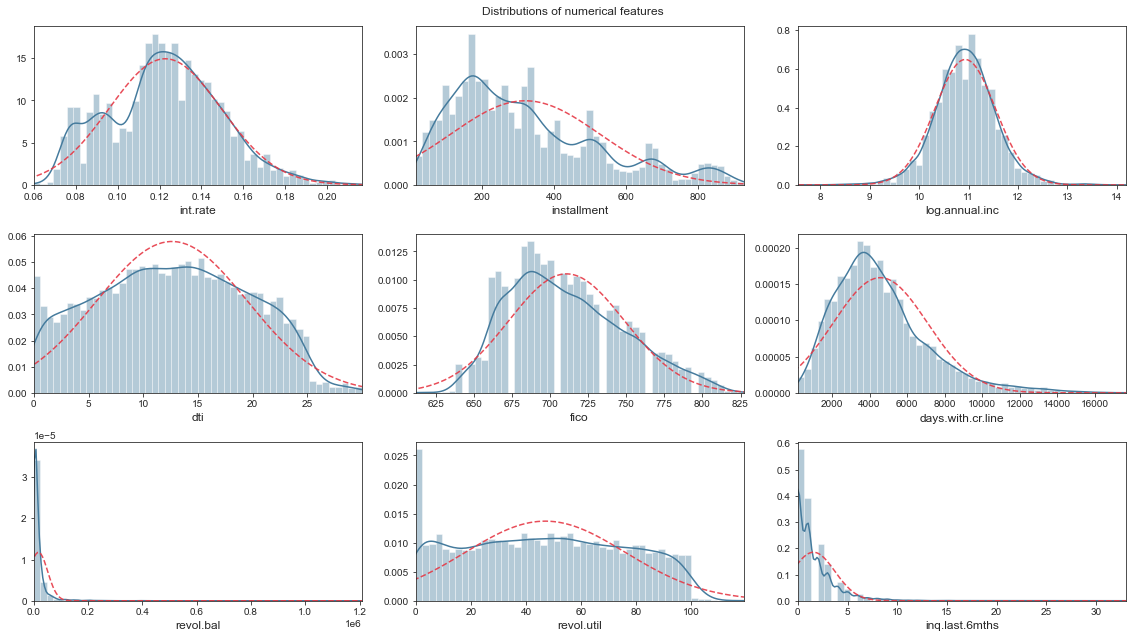

In [13]:
# check the distributions of numerical features
plot_num_distributions(X_train, num_feat.columns)

From the distribution plots of the numerical features, we can observe that expect `log.annual.inc`, almost all features are skewed. different scale.

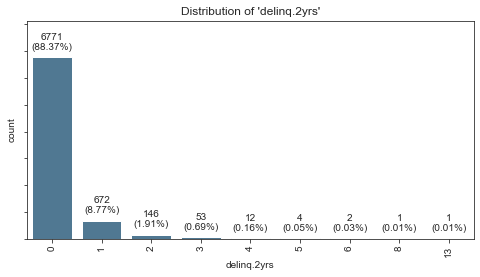

In [14]:
plot_count_pct(X_train, "delinq.2yrs")

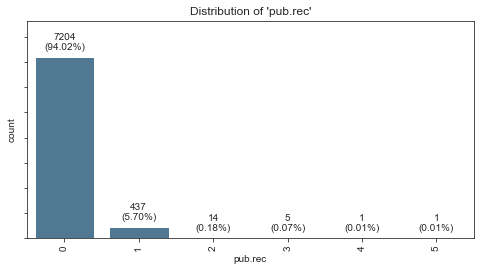

In [15]:
# distribution of the feature 'pub.rec'

plot_count_pct(X_train, "pub.rec")

The detailed distribution plots of `delinq.2yrs` and `pub.rec` suggest that 

### Categorical features

- purpose 
- credit policy

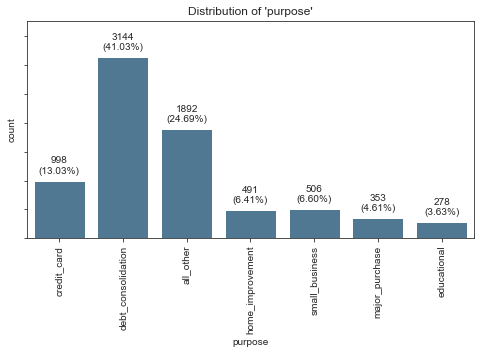

In [16]:
# distribution of the feature 'purpose'

plot_count_pct(X_train, "purpose")

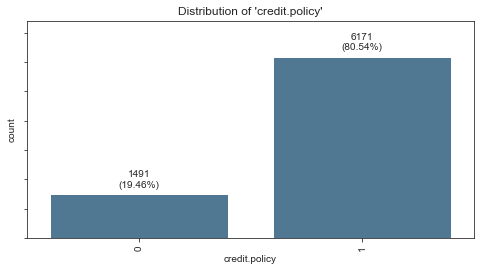

In [17]:
# distribution of the feature 'credit.policy'

plot_count_pct(X_train, "credit.policy")

### The Dependent Variable (The Target Feature)

Positive class ('not.fully.paid' == 1): 16.00%
Negative class ('not.fully.paid' == 0): 84.00%


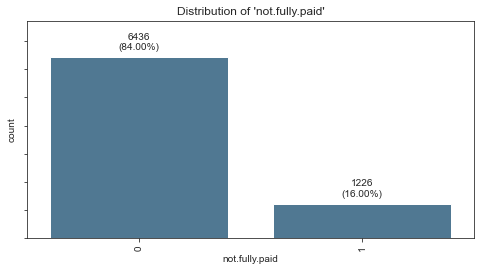

In [18]:
# proportion of the each class

pos_norm = (y_train["not.fully.paid"] == 1).sum() / y_train["not.fully.paid"].count()
neg_norm = (y_train["not.fully.paid"] == 0).sum() / y_train["not.fully.paid"].count()

print("Positive class ('not.fully.paid' == 1): {:.2%}".format(pos_norm))
print("Negative class ('not.fully.paid' == 0): {:.2%}".format(neg_norm))

# distribution of the dependent variable y in the training set 
plot_count_pct(y_train, "not.fully.paid")

#### Independent variable vs. Categorical features

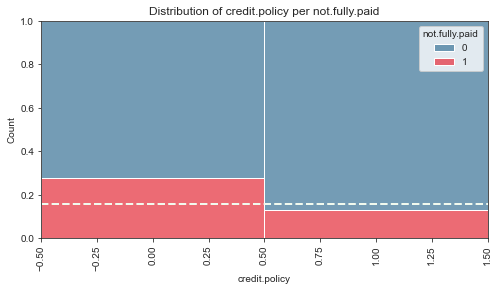

In [19]:
plot_bar_filled(train_set, "credit.policy", "not.fully.paid", ref_line=pos_norm)

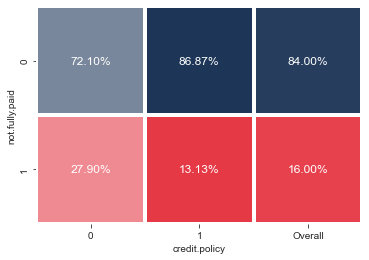

In [20]:
plot_cross_tab(train_set, "credit.policy", "not.fully.paid")

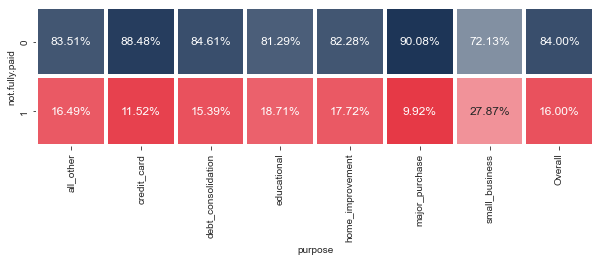

In [21]:
plot_cross_tab(train_set, "purpose", "not.fully.paid")

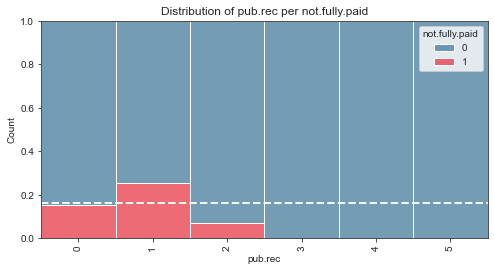

In [22]:
plot_bar_filled(train_set, "pub.rec", "not.fully.paid", ref_line=pos_norm)

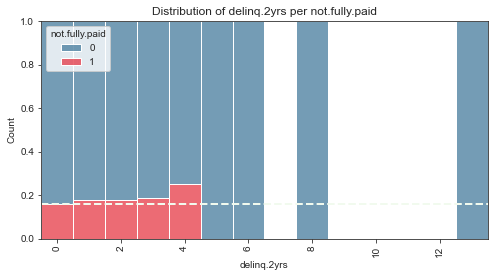

In [23]:
plot_bar_filled(train_set, "delinq.2yrs", "not.fully.paid", ref_line=pos_norm)

In [24]:
train_set[train_set["delinq.2yrs"] > 4]

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
5699,1,credit_card,0.1392,546.20,11.397515,16.51,692,5790.000000,10852,60.9,0,5,0,0
8536,0,all_other,0.1640,353.55,12.388394,12.37,652,5850.958333,188,37.6,1,5,0,0
7952,0,debt_consolidation,0.1470,324.48,11.170435,21.58,657,2984.000000,1992,18.3,3,6,0,0
1525,1,all_other,0.1114,196.84,11.082143,22.41,697,7350.041667,2611,7.8,0,6,0,0
8234,0,debt_consolidation,0.1482,414.93,11.396392,3.49,652,5190.000000,8016,61.7,11,8,0,0
6055,1,debt_consolidation,0.1426,205.84,11.219467,14.05,667,9240.041667,3407,48.7,2,5,0,0
7871,0,debt_consolidation,0.1343,81.37,9.903488,11.64,652,2819.958333,233,15.1,0,5,0,0
7789,0,debt_consolidation,0.1407,171.05,10.714418,0.53,642,2846.000000,123,41.0,6,13,0,0


In [25]:
train_set[train_set["pub.rec"] > 2]

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
7626,1,all_other,0.1422,144.00,10.878047,16.69,667,4710.000000,5804,50.9,0,1,3,0
3461,1,credit_card,0.1316,81.05,11.184421,1.05,697,3630.000000,1229,30.0,1,0,3,0
7276,1,major_purchase,0.1570,350.11,11.196844,3.29,662,6960.000000,4322,86.4,0,0,4,0
7960,0,credit_card,0.1343,169.51,11.492723,12.53,647,2849.958333,9568,97.1,1,0,3,0
6575,1,home_improvement,0.1183,82.84,12.122691,8.45,692,5130.000000,399,39.9,0,1,3,0
8291,0,debt_consolidation,0.1734,687.79,11.242559,12.74,652,6583.000000,20767,81.1,0,0,3,0
8324,0,credit_card,0.1418,287.83,11.379394,1.49,652,3779.041667,2885,15.8,12,0,5,0


#### Independet variable vs. Numerical Features

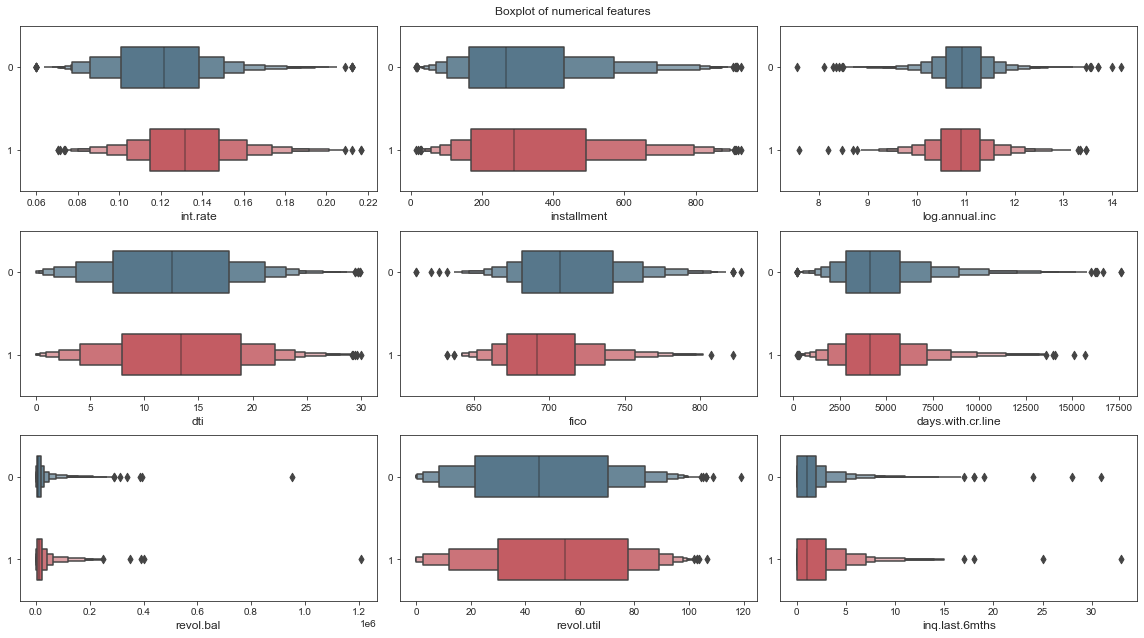

In [26]:
compare_box_distributions(train_set, num_feat.columns, "not.fully.paid")

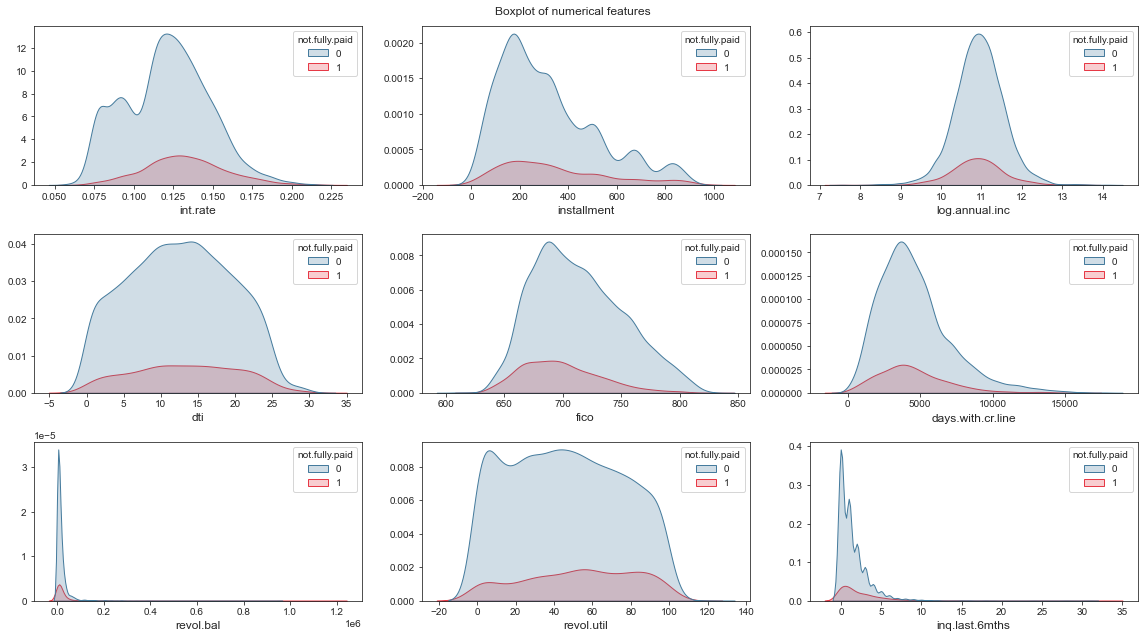

In [27]:
compare_kde_distributions(train_set, num_feat.columns, "not.fully.paid")

In [28]:
# sns.pairplot(train_set, hue="not.fully.paid")

# Feature Engineering

We create a pipeline that can perform the following transformations on both numeric and categorical features:


**Categorical features:**

* convert categorical to numerical representation (One-Hot)

**Numerical features:**

Since linear regression assumes a Gaussian distribution, we need to perform power transformation on the skewed features.

* Feature transformation (log transformation)
* Feature scaling (standardization)

## Feature Scaling 

In [29]:
# turn log_transformer into a 
log_transformer = FunctionTransformer(log_transform)

# 
num_pipeline = Pipeline([
    ("std_scaler", StandardScaler())
])

# combine the pipeline 
final_pipeline = ColumnTransformer([
    ("power_transform", log_transformer, num_feat.columns),
    ("num_pipe", num_pipeline, num_feat.columns),
    ("cat_pipe", OneHotEncoder(drop='first'), cat_feat.columns)
])

In [30]:
def do_feature_engineering(X_train_df):

#     X_train_df["credit.policy"] = X_train_df["credit.policy"].astype("bool")
    X_train_df[["credit.policy", "delinq.2yrs", "pub.rec"]] = X_train_df[["credit.policy", "delinq.2yrs", "pub.rec"]].astype("uint8")
    
    cat_feat = X_train_df.select_dtypes(include=["uint8"])
    bool_feat = X_train_df.select_dtypes(include=["bool"])
    
    # num features:
    cat_OH_transform = pd.get_dummies(X_train_df[["purpose"]], drop_first=False)
    
    num_log_transform = X_train_df[["installment", "fico", "days.with.cr.line", "revol.bal", "inq.last.6mths"]].apply(log_transform)
    num_combined = pd.concat([X_train_df[["int.rate", "log.annual.inc", "dti", "revol.util"]], num_log_transform], axis=1)  
    num_feat_processed = pd.DataFrame(StandardScaler().fit_transform(num_combined), columns=num_combined.columns, index=X_train_df.index)
    
    X_train_df_processed = pd.concat([cat_OH_transform, num_feat_processed, cat_feat], axis=1)
    
    return X_train_df_processed

In [31]:
# fit and transform the features in the training set
# X_train_prepared = final_pipeline.fit_transform(X_train)
X_train_prepared = do_feature_engineering(X_train)
X_train_prepared.describe()

,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,int.rate,log.annual.inc,dti,revol.util,installment,fico,days.with.cr.line,revol.bal,inq.last.6mths,credit.policy,delinq.2yrs,pub.rec
count,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7.662000e+03,7.662000e+03,7.662000e+03,7.662000e+03,7.662000e+03,7.662000e+03,7.662000e+03,7.662000e+03,7.662000e+03,7662.000000,7662.000000,7662.000000
mean,0.246933,0.130253,0.410337,0.036283,0.064082,0.046072,0.066040,-8.201334e-18,-1.431249e-15,9.592373e-17,1.431321e-16,-2.858585e-16,-4.873766e-15,-1.517682e-16,1.551009e-16,-1.182383e-16,0.805403,0.159749,0.063821
std,0.431256,0.336604,0.491927,0.187006,0.244916,0.209654,0.248369,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,0.395916,0.527840,0.267402
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.344681e+00,-5.510290e+00,-1.831965e+00,-1.613689e+00,-3.728786e+00,-2.807985e+00,-5.075728e+00,-3.950224e+00,-1.056638e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.028343e-01,-5.900731e-01,-7.883812e-01,-8.341668e-01,-5.917946e-01,-7.581848e-01,-5.337571e-01,-2.516075e-01,-1.056638e+00,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.215964e-02,-5.166533e-03,2.740337e-03,-1.000222e-02,8.679999e-02,-7.670133e-02,1.008808e-01,2.062421e-01,-1.132017e-02,1.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6.884348e-01,5.991942e-01,7.855190e-01,8.347665e-01,7.511832e-01,7.100019e-01,6.385484e-01,5.519301e-01,6.001513e-01,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.504633e+00,5.282064e+00,2.515032e+00,2.472794e+00,1.771130e+00,2.891351e+00,2.498128e+00,2.470288e+00,4.261376e+00,1.000000,13.000000,5.000000


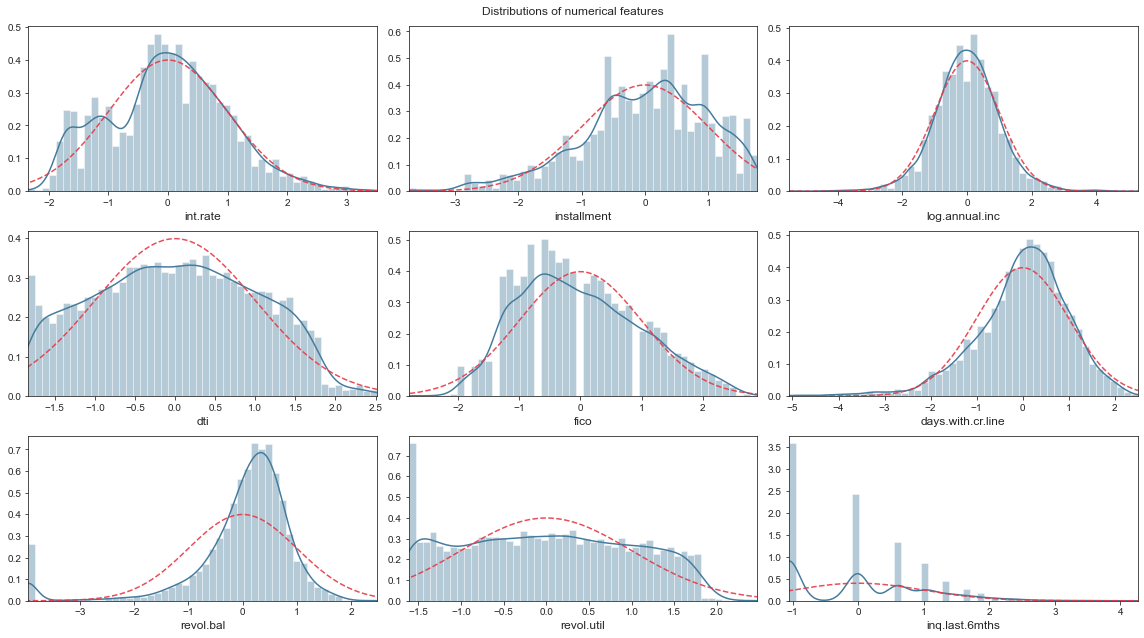

In [32]:
# check the distributions of numerical features
plot_num_distributions(X_train_prepared, num_feat.columns)

In [33]:
X_train_prepared.head()

,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,int.rate,log.annual.inc,dti,revol.util,installment,fico,days.with.cr.line,revol.bal,inq.last.6mths,credit.policy,delinq.2yrs,pub.rec
6381,0,1,0,0,0,0,0,0.744534,0.696658,0.012171,0.951523,1.055304,-0.619914,0.498280,0.510377,-0.011320,1,1,0
7589,0,1,0,0,0,0,0,-1.779946,0.174696,0.017975,-0.150797,-0.663897,0.710002,0.465269,0.346771,-1.056638,1,0,0
465,0,0,1,0,0,0,0,-0.912273,-0.252212,-0.101001,-0.339668,-0.846434,0.189177,0.802967,0.583595,-1.056638,1,1,0
5343,1,0,0,0,0,0,0,0.486476,1.097154,0.506940,0.086150,0.400165,-0.619914,-0.258926,-0.571997,-0.011320,1,0,0
8016,0,0,1,0,0,0,0,0.318178,1.172312,-0.333151,-1.613689,0.749520,-1.321579,-2.933817,-3.950224,1.370514,0,0,0


# Feature Selection 

In [34]:
num_fs = X_train_prepared.select_dtypes(include=["float64"])
cat_fs = X_train_prepared.select_dtypes(include=["uint8", "category"])

print("numerical features contains: ", num_fs.columns)
print("categorical features contains: ", cat_fs.columns)

numerical features contains:  Index(['int.rate', 'log.annual.inc', 'dti', 'revol.util', 'installment',
       'fico', 'days.with.cr.line', 'revol.bal', 'inq.last.6mths'],
      dtype='object')
categorical features contains:  Index(['purpose_all_other', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_major_purchase',
       'purpose_small_business', 'credit.policy', 'delinq.2yrs', 'pub.rec'],
      dtype='object')


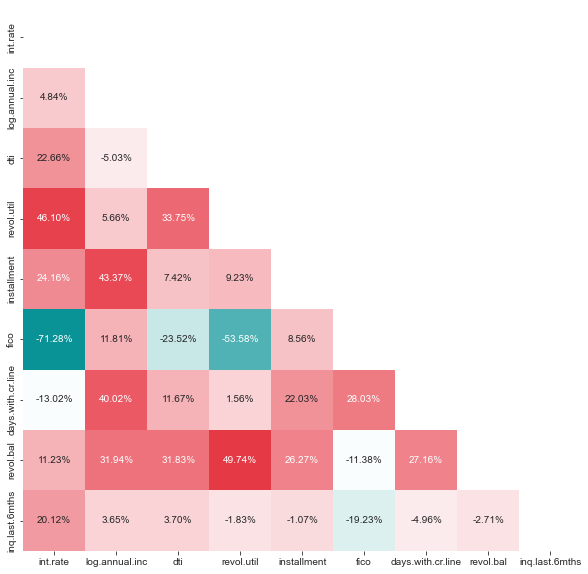

In [35]:
plot_correlations(num_fs)

## Filter Method - Mutual Information 

In [36]:
def model_comparison(X_train, y_train, fs_type):
    
    mod_dummy = DummyClassifier(strategy="constant", constant=0)
    mod_logreg = LogisticRegression(solver='lbfgs')
    mod_logreg_weighted = LogisticRegression(class_weight={0:1, 1:4})
    mod_dt = DecisionTreeClassifier()
    mod_rf = RandomForestClassifier(random_state=random_state)
    mod_xgb = xgb.XGBClassifier(random_state=random_state)
    
    models_dict = {"logistic regression": mod_logreg, 
                   "weighted logistic regression": mod_logreg_weighted, 
                   "decision trees": mod_dt, 
                   "random forest": mod_rf, 
                   "xgboost": mod_xgb}

    results = {"model_name": [],
               "train_recall": [],
               "test_recall": [],
               "train_F2": [],
               "test_F2": [],
               "train_F4": [],
               "test_F4": [],
               "train_accuracy": [],
               "test_accuracy": [],
               "fs_type": []}


    for name, model in models_dict.items():

        score = evaluate_model(X_train, y_train.values.ravel(), model, printing=False)

        results["model_name"].append(name)
        results["train_recall"].append(score["train_recall"])
        results["test_recall"].append(score["test_recall"])
        results["train_F2"].append(score["train_F2"])
        results["test_F2"].append(score["test_F2"])
        results["train_F4"].append(score["train_F4"])
        results["test_F4"].append(score["test_F4"])
        results["train_accuracy"].append(score["train_accuracy"])
        results["test_accuracy"].append(score["test_accuracy"])
        results["fs_type"].append(fs_type)
        

    df = pd.DataFrame(results)

    return df

In [37]:
# without feature selection

comparison_report = model_comparison(X_train_prepared, y_train, fs_type="original")
display(comparison_report)

,model_name,train_recall,test_recall,train_F2,test_F2,train_F4,test_F4,train_accuracy,test_accuracy,fs_type
0,logistic regression,0.021887,0.020668,0.027097,0.025566,0.023199,0.021902,0.840903,0.840468,original
1,weighted logistic regression,0.451400,0.441820,0.403739,0.394617,0.436252,0.426793,0.730010,0.726139,original
2,decision trees,1.000000,0.237376,1.000000,0.232790,1.000000,0.236001,1.000000,0.740624,original
3,random forest,1.000000,0.021483,1.000000,0.026511,1.000000,0.022752,1.000000,0.838815,original
4,xgboost,0.807506,0.080209,0.839675,0.094626,0.816704,0.083971,0.969155,0.827764,original


revol.bal has a MI value of (0)
pub.rec has a MI value of (0)
delinq.2yrs has a MI value of (0)
days.with.cr.line has a MI value of (0)


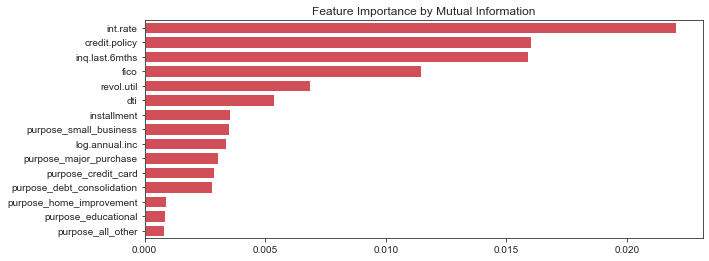

15 features selected by Mutual Information


In [38]:
# mutual infos

selected_features_mi = calculate_mutual_infos(X_train_prepared, X_train_prepared.columns, y_train)
print("{} features selected by Mutual Information".format(len(selected_features_mi)))

In [39]:
# with feature selection (MI)

comparison_report_mi = model_comparison(X_train_prepared[selected_features_mi], y_train, fs_type="mi")
display(comparison_report_mi)

,model_name,train_recall,test_recall,train_F2,test_F2,train_F4,test_F4,train_accuracy,test_accuracy,fs_type
0,logistic regression,0.017333,0.016855,0.021497,0.020896,0.018380,0.017872,0.840718,0.840729,mi
1,weighted logistic regression,0.446371,0.439364,0.398344,0.392331,0.431083,0.424390,0.726388,0.725095,mi
2,decision trees,1.000000,0.235733,1.000000,0.229928,1.000000,0.233987,1.000000,0.735490,mi
3,random forest,1.000000,0.029644,1.000000,0.036315,1.000000,0.031337,1.000000,0.837118,mi
4,xgboost,0.692430,0.070693,0.737544,0.083361,0.705112,0.074000,0.950611,0.824632,mi


## Wrapper Method - RFE (Recursive Feature Elimination)

In [40]:
def apply_feature_selection_RFE():
    
    models = dict()
    
    model = LogisticRegression(solver='lbfgs')
    rfe = RFECV(estimator=model)
    models["lr"] = Pipeline(steps=[("s", rfe), ("m", model)])
    
    model = LogisticRegression(class_weight={0:1, 1:4})
    rfe = RFECV(estimator=model)
    models["lr_weighted"] = Pipeline(steps=[("s", rfe), ("m", model)])
    
    model = DecisionTreeClassifier()
    rfe = RFECV(estimator=model)
    models["dt"] = Pipeline(steps=[("s", rfe), ("m", model)])
    
    
    model = RandomForestClassifier(random_state=random_state)
    rfe = RFECV(estimator=model)
    models["rf"] = Pipeline(steps=[("s", rfe), ("m", model)])
    
    model = xgb.XGBClassifier(random_state=random_state)
    rfe = RFECV(estimator=model)
    models["xgb"] = Pipeline(steps=[("s", rfe), ("m", model)])
    
    return models 

In [41]:
def model_comparison_rfe(X_train, y_train, fs_type):
    
    models = apply_feature_selection_RFE()
    
    models_dict = {"logistic regression": models['lr'], 
                   "weighted logistic regression": models['lr_weighted'], 
                   "decision trees": models['dt'], 
                   "random forest": models['rf'], 
                   "xgboost": models['xgb']}

    results = {"model_name": [],
               "train_recall": [],
               "test_recall": [],
               "train_F2": [],
               "test_F2": [],
               "train_F4": [],
               "test_F4": [],
               "train_accuracy": [],
               "test_accuracy": [],
               "fs_type": []}

    for name, model in models_dict.items():

        score = evaluate_model(X_train, y_train.values.ravel(), model, printing=False)

        results["model_name"].append(name)
        results["train_recall"].append(score["train_recall"])
        results["test_recall"].append(score["test_recall"])
        results["train_F2"].append(score["train_F2"])
        results["test_F2"].append(score["test_F2"])
        results["train_F4"].append(score["train_F4"])
        results["test_F4"].append(score["test_F4"])
        results["train_accuracy"].append(score["train_accuracy"])
        results["test_accuracy"].append(score["test_accuracy"])
        results["fs_type"].append(fs_type)
        

    df = pd.DataFrame(results)

    return df

In [42]:
# with feature selection (RFE)

comparison_report_rfe = model_comparison_rfe(X_train_prepared, y_train, fs_type="rfe")
display(comparison_report_rfe)

KeyboardInterrupt: 

summarize the performance:

* logistic regression (original)
* weighted logistic regression (original)
* decision trees (original)
* random forest (with MI features)
* xgboost (original)

# Dimensionality Reduction

## Principle Component Analysis

In [ ]:
# select only the features 
X_train_fs = X_train_prepared

# retain 99% variances
pca = PCA(n_components=0.99, whiten=True)

X_train_pca = pca.fit_transform(X_train_fs)

print("Dimensionality reduction using PCA:")
print("Original number of features: {}".format(X_train_fs.shape[1]))
print("Reduced number of features: {}".format(X_train_pca.shape[1]))

comparison_report_pca99 = model_comparison(X_train_pca, y_train, fs_type="pca99")
display(comparison_report_pca99)

with PCA, tree-based models have a better performance.

In [ ]:
# retain 95% variances
pca = PCA(n_components=0.95, whiten=True)

X_train_pca = pca.fit_transform(X_train_fs)

print("Dimensionality reduction using PCA:")
print("Original number of features: {}".format(X_train_fs.shape[1]))
print("Reduced number of features: {}".format(X_train_pca.shape[1]))

comparison_report_pca95 = model_comparison(X_train_pca, y_train, fs_type="pca95")
display(comparison_report_pca95)

In [ ]:
# retain 90% variances
pca = PCA(n_components=0.9, whiten=True)

X_train_pca = pca.fit_transform(X_train_fs)

print("Dimensionality reduction using PCA:")
print("Original number of features: {}".format(X_train_fs.shape[1]))
print("Reduced number of features: {}".format(X_train_pca.shape[1]))

comparison_report_pca90 = model_comparison(X_train_pca, y_train, fs_type="pca90")
display(comparison_report_pca90)

# Modeling

## Metrics 

$$
\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

$$
\text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

$$
\text{F}_\text{beta} = (1 + \beta^2) \cdot \frac{\text{precision} \cdot \text{recall}}{\beta^2 \cdot \text{precision} + \text{recall} }
$$

## Dummy Classifier

Model Result: <<  dummy classifier  >>

Confusion matrix:


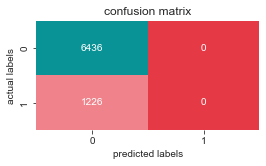

Classification report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      6436
           1       0.00      0.00      0.00      1226

    accuracy                           0.84      7662
   macro avg       0.42      0.50      0.46      7662
weighted avg       0.71      0.84      0.77      7662



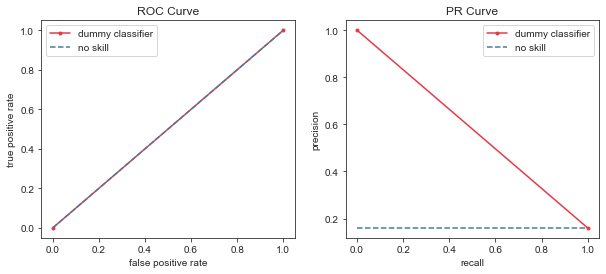

Model evaluation using K fold stratification
<<<   DummyClassifier(constant=0, strategy='constant')   >>>
------------------------------------------------------------
mean recall scores, train: 0.0000, test: 0.0000
mean F1 scores, train: 0.0000, test: 0.0000
mean F2 scores, train: 0.0000, test: 0.0000
mean F4 scores, train: 0.0000, test: 0.0000
mean accuracy scores, train: 0.8400, test: 0.8400


In [42]:
# a dummy classifier with a constant value

mod_dummy = DummyClassifier(strategy="constant", constant=0)
report_model_result(X_train_prepared, y_train, mod_dummy, "dummy classifier")

scores_dummy = evaluate_model(X_train_prepared, y_train.values.ravel(), mod_dummy)

## Logistic Regression

Model Result: <<  logistic regression  >>

Confusion matrix:


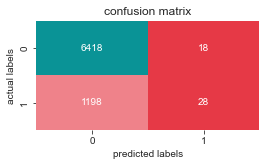

Classification report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      6436
           1       0.61      0.02      0.04      1226

    accuracy                           0.84      7662
   macro avg       0.73      0.51      0.48      7662
weighted avg       0.81      0.84      0.77      7662



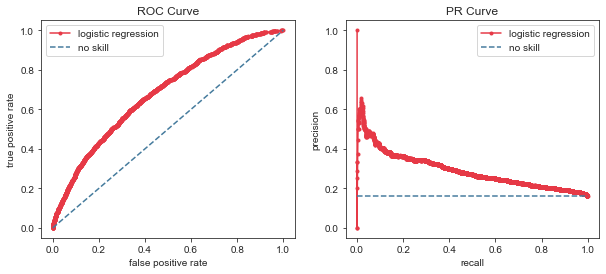

Model evaluation using K fold stratification
<<<   LogisticRegression()   >>>
------------------------------------------------------------
mean recall scores, train: 0.0219, test: 0.0207
mean F1 scores, train: 0.0421, test: 0.0397
mean F2 scores, train: 0.0271, test: 0.0256
mean F4 scores, train: 0.0232, test: 0.0219
mean accuracy scores, train: 0.8409, test: 0.8405


In [43]:
# a simple logisitic regression model

mod_logreg = LogisticRegression(solver='lbfgs')
report_model_result(X_train_prepared, y_train, mod_logreg, "logistic regression")

# evaluate the model based on CV 
scores_logreg = evaluate_model(X_train_prepared, y_train.values.ravel(), mod_logreg)

## Weighted Logistic Regression

Model Result: <<  weighted logistic regression  >>

Confusion matrix:


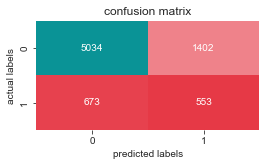

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      6436
           1       0.28      0.45      0.35      1226

    accuracy                           0.73      7662
   macro avg       0.58      0.62      0.59      7662
weighted avg       0.79      0.73      0.75      7662



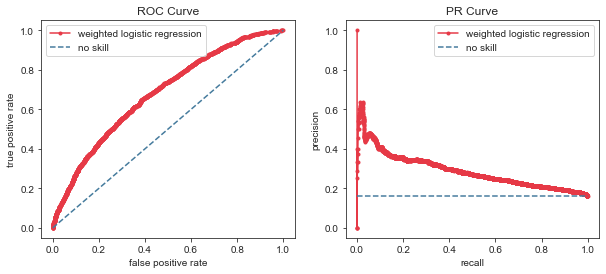

Model evaluation using K fold stratification
<<<   LogisticRegression(class_weight={0: 1, 1: 4})   >>>
------------------------------------------------------------
mean recall scores, train: 0.4514, test: 0.4418
mean F1 scores, train: 0.3485, test: 0.3402
mean F2 scores, train: 0.4037, test: 0.3946
mean F4 scores, train: 0.4363, test: 0.4268
mean accuracy scores, train: 0.7300, test: 0.7261


In [44]:
# weighted logisitc regression 
# define model
mod_logreg_weighted = LogisticRegression(class_weight={0:1, 1:4})

report_model_result(X_train_prepared, y_train, mod_logreg_weighted, "weighted logistic regression")
scores_logreg_weighted = evaluate_model(X_train_prepared, y_train.values.ravel(), mod_logreg_weighted)

## Decision Tree

Model Result: <<  decision tree  >>

Confusion matrix:


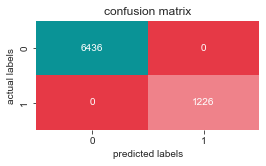

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6436
           1       1.00      1.00      1.00      1226

    accuracy                           1.00      7662
   macro avg       1.00      1.00      1.00      7662
weighted avg       1.00      1.00      1.00      7662



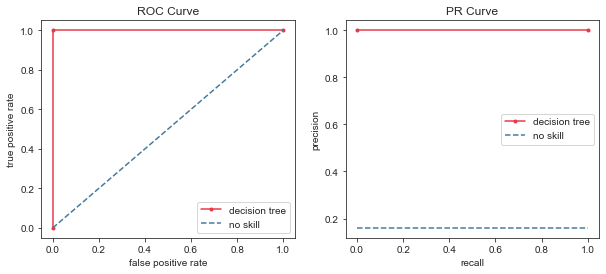

Model evaluation using K fold stratification
<<<   DecisionTreeClassifier()   >>>
------------------------------------------------------------
mean recall scores, train: 1.0000, test: 0.2382
mean F1 scores, train: 1.0000, test: 0.2261
mean F2 scores, train: 1.0000, test: 0.2332
mean F4 scores, train: 1.0000, test: 0.2367
mean accuracy scores, train: 1.0000, test: 0.7394


In [45]:
# decision tree model 
mod_dt = DecisionTreeClassifier()
report_model_result(X_train_prepared, y_train, mod_dt, "decision tree")

scores_dt = evaluate_model(X_train_prepared, y_train.values.ravel(), mod_dt)

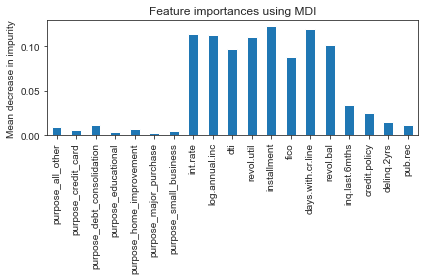

In [46]:
# feature importance

dt_importances = pd.Series(mod_dt.feature_importances_, index=X_train_prepared.columns)

fig, ax = plt.subplots()
dt_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Random Forest

Model Result: <<  random forest  >>

Confusion matrix:


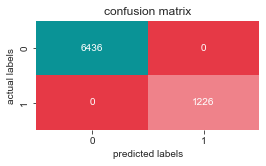

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6436
           1       1.00      1.00      1.00      1226

    accuracy                           1.00      7662
   macro avg       1.00      1.00      1.00      7662
weighted avg       1.00      1.00      1.00      7662



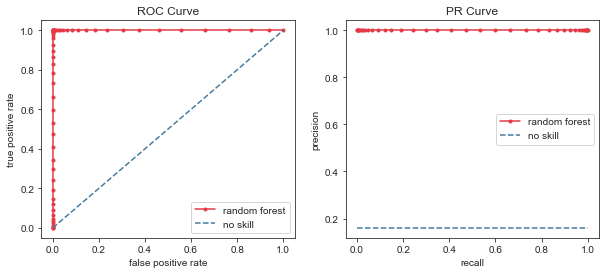

Model evaluation using K fold stratification
<<<   RandomForestClassifier(random_state=42)   >>>
------------------------------------------------------------
mean recall scores, train: 1.0000, test: 0.0215
mean F1 scores, train: 1.0000, test: 0.0409
mean F2 scores, train: 1.0000, test: 0.0265
mean F4 scores, train: 1.0000, test: 0.0228
mean accuracy scores, train: 1.0000, test: 0.8388


In [47]:
# random forest model 
mod_rf = RandomForestClassifier(random_state=random_state)
report_model_result(X_train_prepared, y_train, mod_rf, "random forest")

scores_rf = evaluate_model(X_train_prepared, y_train.values.ravel(), mod_rf)

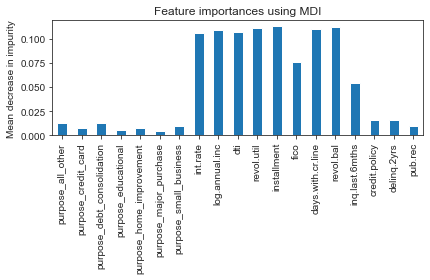

In [48]:
# feature importance

rf_importances = pd.Series(mod_rf.feature_importances_, index=X_train_prepared.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [49]:
rf_importances

purpose_all_other             0.012380
purpose_credit_card           0.007274
purpose_debt_consolidation    0.013239
purpose_educational           0.005607
purpose_home_improvement      0.007488
purpose_major_purchase        0.004163
purpose_small_business        0.009323
int.rate                      0.106366
log.annual.inc                0.109123
dti                           0.106644
revol.util                    0.111652
installment                   0.113470
fico                          0.075708
days.with.cr.line             0.110005
revol.bal                     0.112318
inq.last.6mths                0.054380
credit.policy                 0.016064
delinq.2yrs                   0.015397
pub.rec                       0.009398
dtype: float64

## XGBoost

Model Result: <<  XGBoost  >>

[10:10:20] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion matrix:


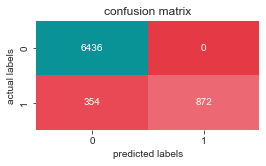

Classification report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      6436
           1       1.00      0.71      0.83      1226

    accuracy                           0.95      7662
   macro avg       0.97      0.86      0.90      7662
weighted avg       0.96      0.95      0.95      7662



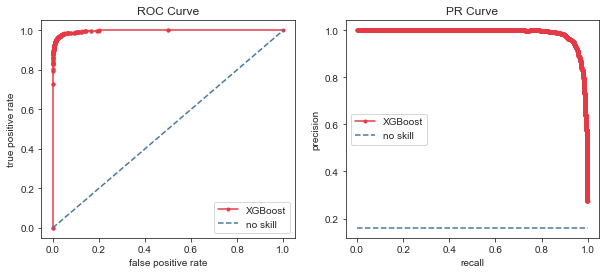

Model evaluation using K fold stratification
<<<   XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)   >>>
------------------------------------------------------------
mean recall scores, train: 0.8075, test: 0.0802
mean F1 scores, train: 0.8931, test: 0.1296
mean F2 scores, train: 0.8397, test: 0.0946
mean F4 scores, train: 0.8167, test: 0.0840
mean accuracy scores, train: 0.9692, test: 0.8278


In [50]:
mod_xgb = xgb.XGBClassifier()

report_model_result(X_train_prepared, y_train, mod_xgb, "XGBoost")

scores_xgb = evaluate_model(X_train_prepared, y_train.values.ravel(), mod_xgb)

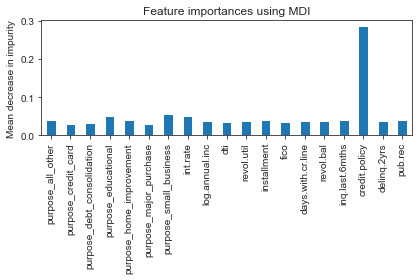

In [51]:
# feature importance

xgb_importances = pd.Series(mod_xgb.feature_importances_, index=X_train_prepared.columns)

fig, ax = plt.subplots()
xgb_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Number of Features - Mutual Information

In [52]:
def tuning_feature_selection_kbest(X, y, model, model_name):
    
    fs = SelectKBest(score_func=mutual_info_classif)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=random_state)

    pipeline = Pipeline(steps=[("mutual_info",fs), (model_name, model)])

    grid = dict()

    grid["mutual_info__k"] = [i+1 for i in range(X.shape[1])]

    metric2 = make_scorer(f2_measure)
    search = GridSearchCV(pipeline, grid, scoring=metric2, n_jobs=-1, cv=cv)

    results = search.fit(X, y.values.ravel())
    
    print("Model name: ", model_name)
    print("Best Mean F2 score: {:.3f}".format(results.best_score_))
    print("Best Config: {}".format(results.best_params_))
    
    return results

In [53]:
# logistic regression 
logreg_kbest = tuning_feature_selection_kbest(X_train_prepared, y_train, mod_logreg, 'Logistic Regression')

Model name:  Logistic Regression
Best Mean F2 score: 0.026
Best Config: {'mutual_info__k': 18}


In [54]:
# weighted logistic regression 
logreg_weighted_kbest = tuning_feature_selection_kbest(X_train_prepared, y_train, mod_logreg_weighted, 'Weighted Logistic Regression')

Model name:  Weighted Logistic Regression
Best Mean F2 score: 0.395
Best Config: {'mutual_info__k': 18}


In [55]:
# decision trees
dt_kbest = tuning_feature_selection_kbest(X_train_prepared, y_train, mod_dt, 'Decision Trees')

Model name:  Decision Trees
Best Mean F2 score: 0.237
Best Config: {'mutual_info__k': 15}


In [56]:
# random forest
rf_kbest = tuning_feature_selection_kbest(X_train_prepared, y_train, mod_rf, 'Random Forest')

Model name:  Random Forest
Best Mean F2 score: 0.118
Best Config: {'mutual_info__k': 4}


In [57]:
# xgboost 
xgb_kbest = tuning_feature_selection_kbest(X_train_prepared, y_train, mod_xgb, 'XGBoost')

[10:15:54] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model name:  XGBoost
Best Mean F2 score: 0.096
Best Config: {'mutual_info__k': 12}


Model Result: <<  Random Forest 10 Feat  >>

Confusion matrix:


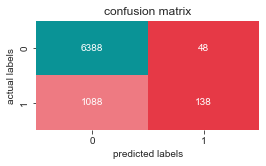

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      6436
           1       0.74      0.11      0.20      1226

    accuracy                           0.85      7662
   macro avg       0.80      0.55      0.56      7662
weighted avg       0.84      0.85      0.80      7662



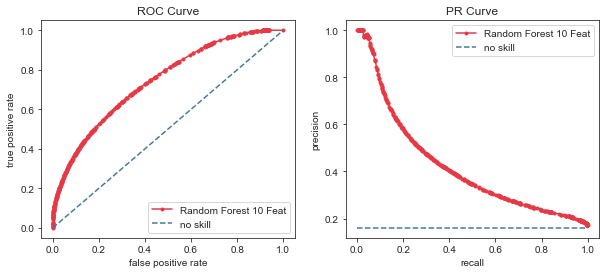

Model evaluation using K fold stratification
<<<   RandomForestClassifier(random_state=42)   >>>
------------------------------------------------------------
mean recall scores, train: 0.1387, test: 0.0601
mean F1 scores, train: 0.2326, test: 0.0999
mean F2 scores, train: 0.1654, test: 0.0715
mean F4 scores, train: 0.1456, test: 0.0630
mean accuracy scores, train: 0.8538, test: 0.8268


In [58]:
X_train_kbest_3 = SelectKBest(score_func=mutual_info_classif, k=3).fit_transform(X_train_prepared, y_train)

# random forest with 3 best features 
report_model_result(X_train_kbest_3, y_train, mod_rf, "Random Forest 10 Feat")
scores_rf = evaluate_model(X_train_kbest_3, y_train.values.ravel(), mod_rf)

# Resampling  - SMOTE

In [59]:

smote = SMOTE(sampling_strategy='auto', random_state=random_state, k_neighbors=5)
X_train_prepared_smt, y_train_smt = smote.fit_resample(X_train_prepared, y_train)

In [60]:
models_dict = {"dummy model": mod_dummy, 
               "logistic regression": mod_logreg, 
               "weighted logistic regression": mod_logreg_weighted, 
               "decision trees": mod_dt, 
               "random forest": mod_rf, 
               "xgboost": mod_xgb}

smote_results = {"model_name": [],
                 "train_recall": [],
                 "test_recall": [],
                 "train_F2": [],
                 "test_F2": [],
                 "train_F4": [],
                 "test_F4": [],
                 "train_accuracy": [],
                 "test_accuracy": [],
                 "sampling_strategy": []}

for name, model in models_dict.items():

    smote_score = evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), model, printing=False)
    
    smote_results["model_name"].append(name)
    smote_results["train_recall"].append(smote_score["train_recall"])
    smote_results["test_recall"].append(smote_score["test_recall"])
    smote_results["train_F2"].append(smote_score["train_F2"])
    smote_results["test_F2"].append(smote_score["test_F2"])
    smote_results["train_F4"].append(smote_score["train_F4"])
    smote_results["test_F4"].append(smote_score["test_F4"])
    smote_results["train_accuracy"].append(smote_score["train_accuracy"])
    smote_results["test_accuracy"].append(smote_score["test_accuracy"])
    smote_results["sampling_strategy"].append("auto")

smote_df = pd.DataFrame(smote_results)
display(smote_df)

,model_name,train_recall,test_recall,train_F2,test_F2,train_F4,test_F4,train_accuracy,test_accuracy,sampling_strategy
0,dummy model,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,auto
1,logistic regression,0.630555,0.628807,0.647972,0.646192,0.635579,0.633821,0.697768,0.696085,auto
2,weighted logistic regression,0.976655,0.975554,0.843160,0.842133,0.933198,0.932119,0.580834,0.579475,auto
3,decision trees,1.000000,0.824219,1.000000,0.814812,1.000000,0.821428,1.000000,0.795396,auto
4,random forest,1.000000,0.895329,1.000000,0.896578,1.000000,0.895695,1.000000,0.898824,auto
5,xgboost,0.957375,0.837943,0.965292,0.854794,0.959690,0.842829,0.977885,0.887275,auto


In [61]:
# grid search k value for SMOTE oversampling for imbalanced classification

sampling_strategies = [0.2, 0.4, 0.6, 0.8, 1]
smote_results = {"model_name": [],
                 "train_recall": [],
                 "test_recall": [],
                 "train_F2": [],
                 "test_F2": [],
                 "train_F4": [],
                 "test_F4": [],
                 "train_accuracy": [],
                 "test_accuracy": [],
                 "sampling_strategy": []}

for s in sampling_strategies:
    smote = SMOTE(sampling_strategy=s, random_state=random_state, k_neighbors=5)
    X_train_prepared_s, y_train_s = smote.fit_resample(X_train_prepared, y_train)
    
    for name, model in models_dict.items():

        smote_score = evaluate_model(X_train_prepared_s, y_train_s.values.ravel(), model, printing=False)
        smote_results["model_name"].append(name)
        smote_results["train_recall"].append(smote_score["train_recall"])
        smote_results["test_recall"].append(smote_score["test_recall"])
        smote_results["train_F2"].append(smote_score["train_F2"])
        smote_results["test_F2"].append(smote_score["test_F2"])
        smote_results["train_F4"].append(smote_score["train_F4"])
        smote_results["test_F4"].append(smote_score["test_F4"])
        smote_results["train_accuracy"].append(smote_score["train_accuracy"])
        smote_results["test_accuracy"].append(smote_score["test_accuracy"])
        smote_results["sampling_strategy"].append(s)
        
smote_df = pd.concat([smote_df, pd.DataFrame(smote_results)])
smote_df = smote_df.reset_index(drop=True)
display(smote_df)

,model_name,train_recall,test_recall,train_F2,test_F2,train_F4,test_F4,train_accuracy,test_accuracy,sampling_strategy
0,dummy model,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,auto
1,logistic regression,0.630555,0.628807,0.647972,0.646192,0.635579,0.633821,0.697768,0.696085,auto
2,weighted logistic regression,0.976655,0.975554,0.843160,0.842133,0.933198,0.932119,0.580834,0.579475,auto
3,decision trees,1.000000,0.824219,1.000000,0.814812,1.000000,0.821428,1.000000,0.795396,auto
4,random forest,1.000000,0.895329,1.000000,0.896578,1.000000,0.895695,1.000000,0.898824,auto
5,xgboost,0.957375,0.837943,0.965292,0.854794,0.959690,0.842829,0.977885,0.887275,auto
6,dummy model,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.833355,0.833355,0.2
7,logistic regression,0.029331,0.027453,0.036234,0.033884,0.031072,0.029076,0.835319,0.834693,0.2
8,weighted logistic regression,0.479927,0.470321,0.425305,0.416659,0.462457,0.453144,0.719668,0.716345,0.2
9,decision trees,1.000000,0.254851,1.000000,0.249873,1.000000,0.253361,1.000000,0.735465,0.2


## Visualizing Sampling Result

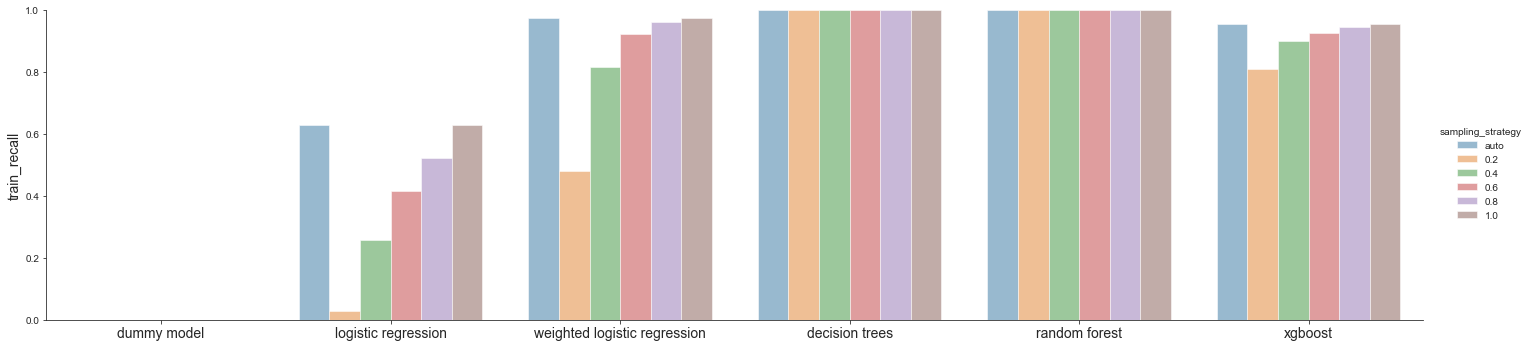

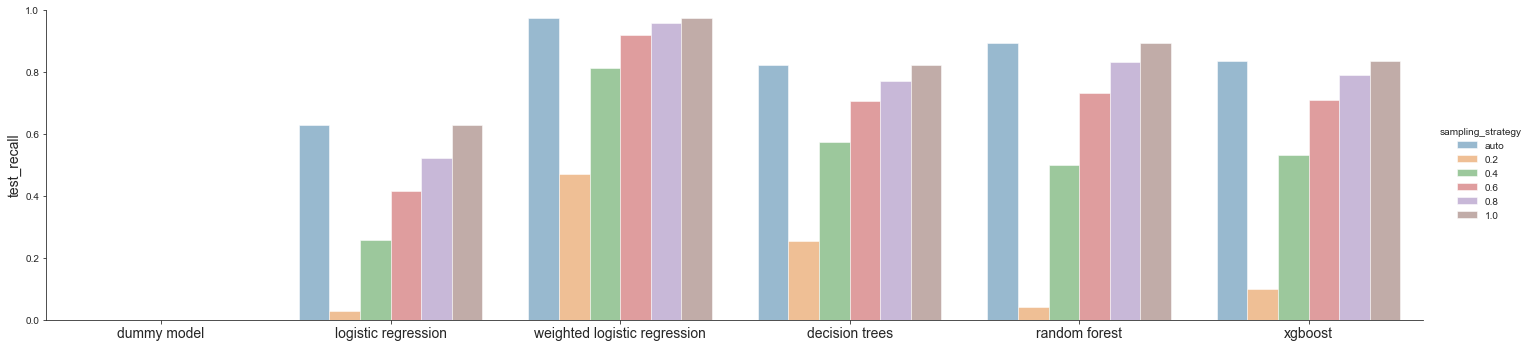

In [62]:
# compare recall 
g1 = sns.catplot(x="model_name", y="train_recall", hue="sampling_strategy", data=smote_df, \
            kind="bar", aspect=4, height=5, alpha=0.5)

(g1.set_titles("").set_axis_labels("").set(ylim=(0, 1)).set_xticklabels(fontsize=14).set_ylabels(fontsize=14))
g2 = sns.catplot(x="model_name", y="test_recall", hue="sampling_strategy", data=smote_df, \
            kind="bar", aspect=4, height=5, alpha=0.5)
(g2.set_titles("").set_axis_labels("").set(ylim=(0,1)).set_xticklabels(fontsize=14).set_ylabels(fontsize=14))
plt.show()

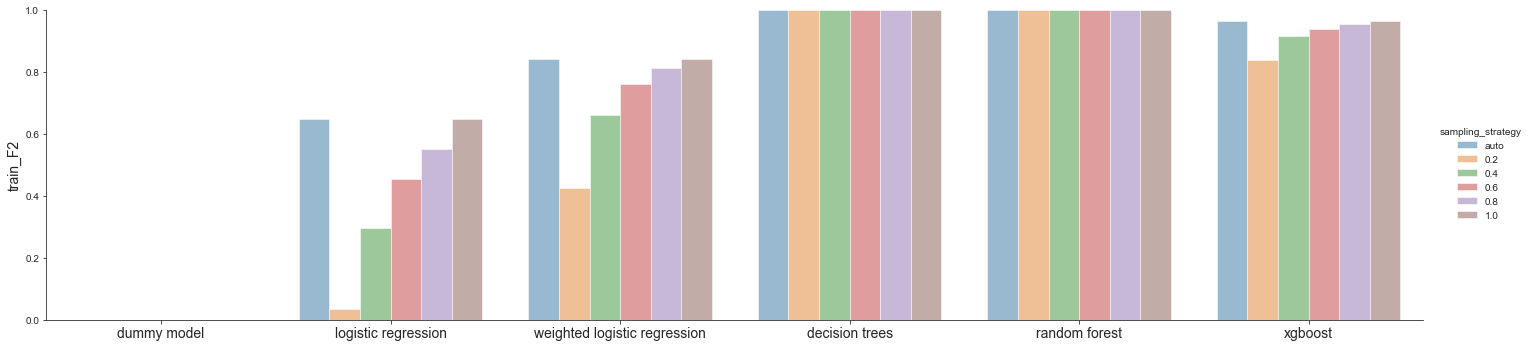

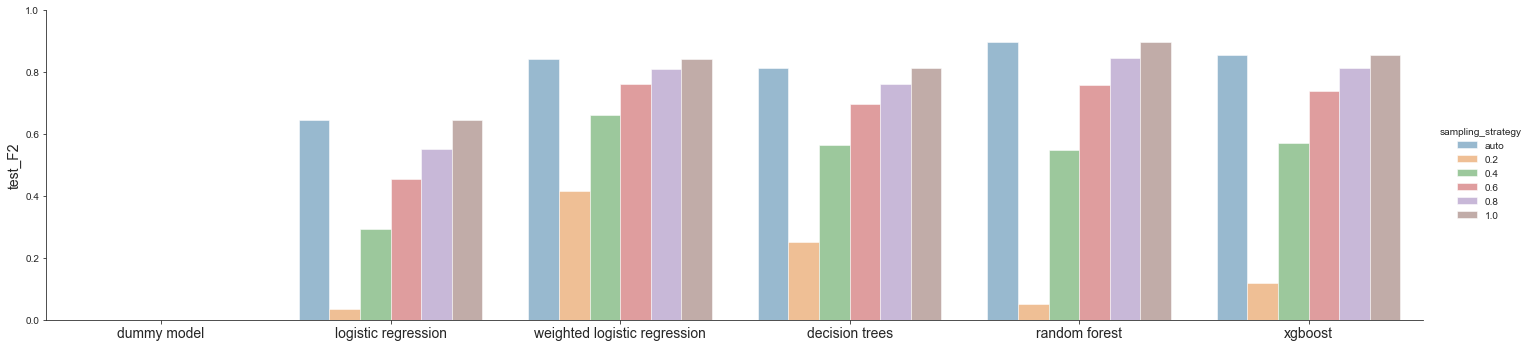

In [63]:
# compare F2 score 
g1 = sns.catplot(x="model_name", y="train_F2", hue="sampling_strategy", data=smote_df, \
            kind="bar", aspect=4, height=5, alpha=0.5)

(g1.set_titles("").set_axis_labels("").set(ylim=(0, 1)).set_xticklabels(fontsize=14).set_ylabels(fontsize=14))
g2 = sns.catplot(x="model_name", y="test_F2", hue="sampling_strategy", data=smote_df, \
            kind="bar", aspect=4, height=5, alpha=0.5)
(g2.set_titles("").set_axis_labels("").set(ylim=(0, 1)).set_xticklabels(fontsize=14).set_ylabels(fontsize=14))
plt.show()

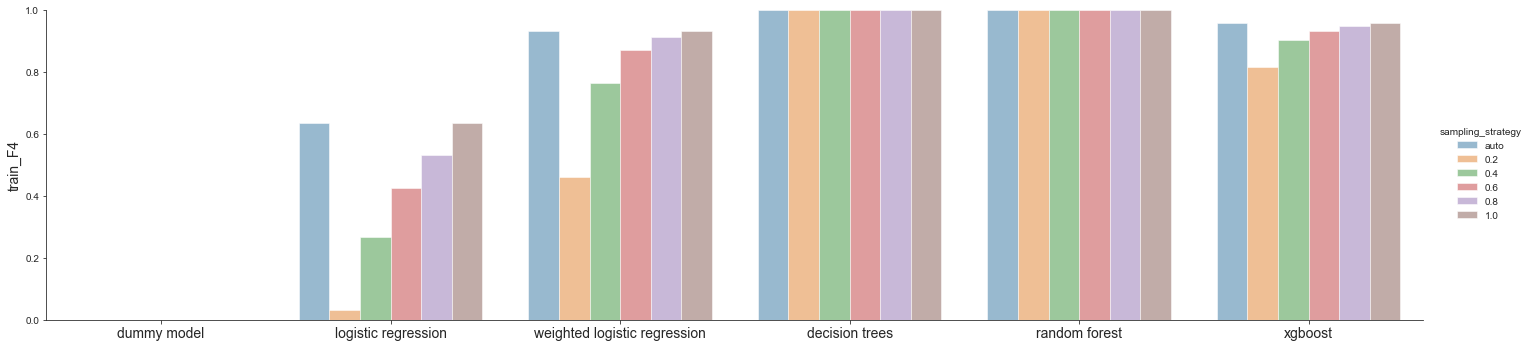

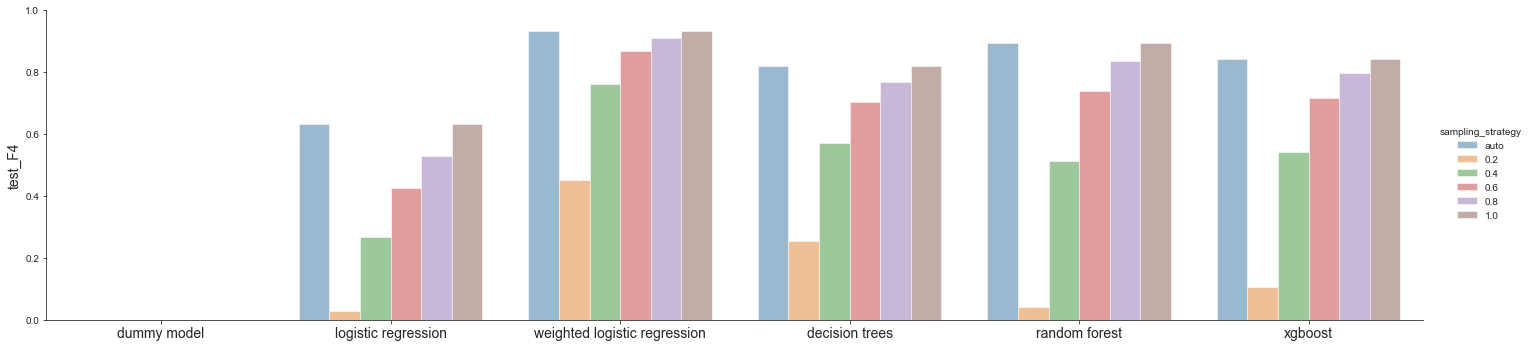

In [64]:
# compare F4 score 
g1 = sns.catplot(x="model_name", y="train_F4", hue="sampling_strategy", data=smote_df, \
            kind="bar", aspect=4, height=5, alpha=0.5)

(g1.set_titles("").set_axis_labels("").set(ylim=(0,1)).set_xticklabels(fontsize=14).set_ylabels(fontsize=14))
g2 = sns.catplot(x="model_name", y="test_F4", hue="sampling_strategy", data=smote_df, \
            kind="bar", aspect=4, height=5, alpha=0.5)
(g2.set_titles("").set_axis_labels("").set(ylim=(0,1)).set_xticklabels(fontsize=14).set_ylabels(fontsize=14))
plt.show()

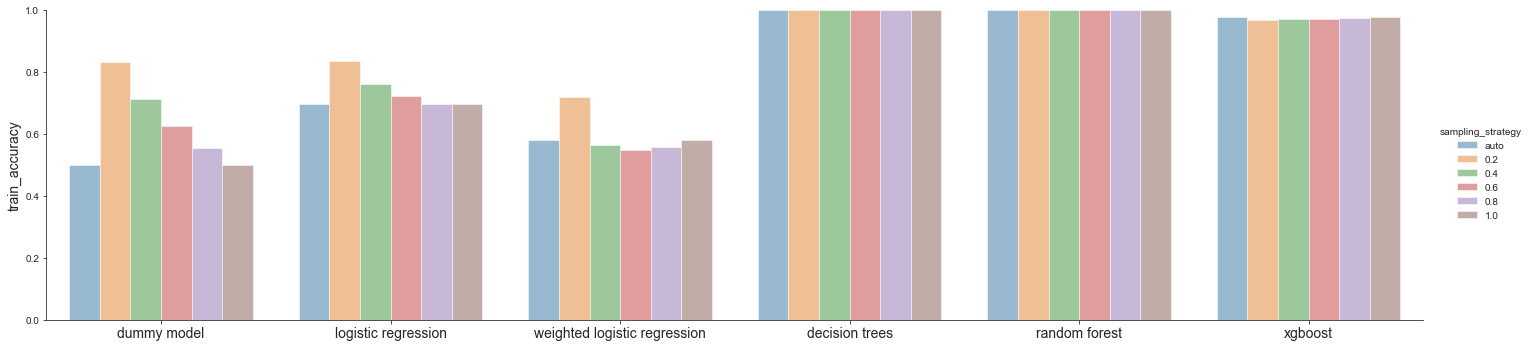

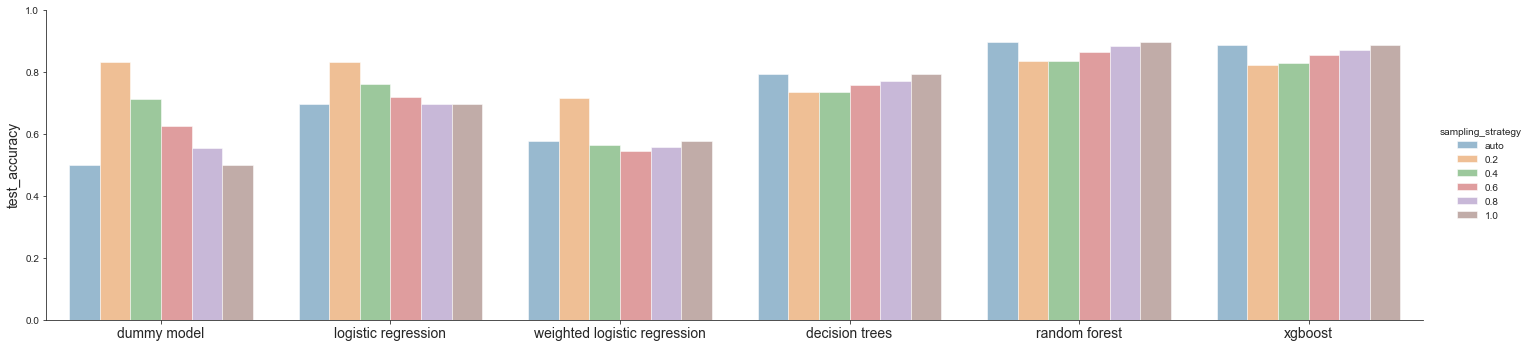

In [65]:
# compare accuracy score 
g1 = sns.catplot(x="model_name", y="train_accuracy", hue="sampling_strategy", data=smote_df, \
            kind="bar", aspect=4, height=5, alpha=0.5)

(g1.set_titles("").set_axis_labels("").set(ylim=(0,1)).set_xticklabels(fontsize=14).set_ylabels(fontsize=14))
g2 = sns.catplot(x="model_name", y="test_accuracy", hue="sampling_strategy", data=smote_df, \
            kind="bar", aspect=4, height=5, alpha=0.5)
(g2.set_titles("").set_axis_labels("").set(ylim=(0,1)).set_xticklabels(fontsize=14).set_ylabels(fontsize=14))
plt.show()

"auto" strategy outperforms all the rest 

# Feature Selection after Resampling

In [66]:
# combine the comparison_report 

comparison_report_df = pd.concat([comparison_report, comparison_report_mi, comparison_report_rfe, \
                                  comparison_report_pca90, comparison_report_pca95, comparison_report_pca99], axis=0)
comparison_report_df = comparison_report_df.reset_index(drop=True)

NameError: name 'comparison_report_rfe' is not defined

In [67]:
# compare accuracy score 
g1 = sns.catplot(x="model_name", y="train_recall", hue="fs_type", data=comparison_report_df, \
            kind="bar", aspect=4, height=5, alpha=0.5)

(g1.set_titles("").set_axis_labels("").set(ylim=(0, 1)).set_xticklabels(fontsize=14).set_ylabels(fontsize=14))
g2 = sns.catplot(x="model_name", y="test_recall", hue="fs_type", data=comparison_report_df, \
            kind="bar", aspect=4, height=5, alpha=0.5)
(g2.set_titles("").set_axis_labels("").set(ylim=(0, 1)).set_xticklabels(fontsize=14).set_ylabels(fontsize=14))
plt.show()

NameError: name 'comparison_report_df' is not defined

In [ ]:
# compare F2 score 
g1 = sns.catplot(x="model_name", y="train_F2", hue="fs_type", data=comparison_report_df, \
            kind="bar", aspect=4, height=5, alpha=0.5)

(g1.set_titles("").set_axis_labels("").set(ylim=(0, 1)).set_xticklabels(fontsize=14).set_ylabels(fontsize=14))
g2 = sns.catplot(x="model_name", y="test_F2", hue="fs_type", data=comparison_report_df, \
            kind="bar", aspect=4, height=5, alpha=0.5)
(g2.set_titles("").set_axis_labels("").set(ylim=(0, 1)).set_xticklabels(fontsize=14).set_ylabels(fontsize=14))
plt.show()

In [ ]:
# compare F4 score 
g1 = sns.catplot(x="model_name", y="train_F4", hue="fs_type", data=comparison_report_df, \
            kind="bar", aspect=4, height=5, alpha=0.5)

(g1.set_titles("").set_axis_labels("").set(ylim=(0, 1)).set_xticklabels(fontsize=14).set_ylabels(fontsize=14))
g2 = sns.catplot(x="model_name", y="test_F4", hue="fs_type", data=comparison_report_df, \
            kind="bar", aspect=4, height=5, alpha=0.5)
(g2.set_titles("").set_axis_labels("").set(ylim=(0, 1)).set_xticklabels(fontsize=14).set_ylabels(fontsize=14))
plt.show()

After SMOTE resampling, the "mutual informaion" strategy seems to be more appropriate for tree-based models, whileas original features are more .. for regression models.

# Which Metric to Use?

# Hyperparameter Tuning


## Logistic Regression

Best score: 0.6485
Best params: 


{'C': 0.01, 'penalty': 'l2'}

Model Result: <<  Best LogReg  >>

Confusion matrix:


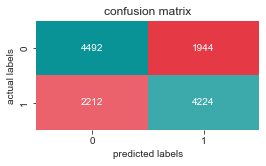

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      6436
           1       0.68      0.66      0.67      6436

    accuracy                           0.68     12872
   macro avg       0.68      0.68      0.68     12872
weighted avg       0.68      0.68      0.68     12872



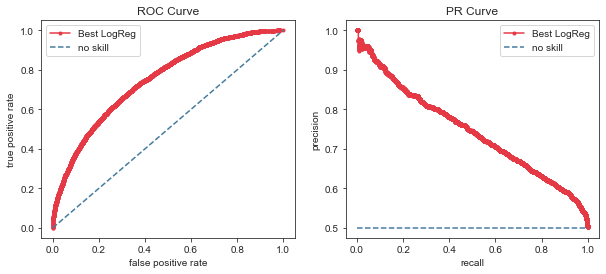

Model evaluation using K fold stratification
<<<   LogisticRegression(C=0.01)   >>>
------------------------------------------------------------
mean recall scores, train: 0.6549, test: 0.6539
mean F1 scores, train: 0.6674, test: 0.6663
mean F2 scores, train: 0.6598, test: 0.6588
mean F4 scores, train: 0.6563, test: 0.6554
mean accuracy scores, train: 0.6736, test: 0.6726


{'train_recall': 0.6548581512069569,
 'test_recall': 0.6539256234908409,
 'train_F2': 0.6597980643844044,
 'test_F2': 0.6588192694090318,
 'train_F4': 0.6563031861962441,
 'test_F4': 0.6553560690159124,
 'train_accuracy': 0.6735873626887953,
 'test_accuracy': 0.6725712087265485}

In [68]:
# recall score 
param_grid = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

gscv_logreg = GridSearchCV(mod_logreg, param_grid, cv=5,
                          scoring="recall",
                          return_train_score=True)

gscv_logreg.fit(X_train_prepared_smt, y_train_smt)

print("Best score: {:.4f}".format(gscv_logreg.best_score_))
print("Best params: ")
display(gscv_logreg.best_params_)

best_logreg = gscv_logreg.best_estimator_

report_model_result(X_train_prepared_smt, y_train_smt, best_logreg, "Best LogReg")
evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), best_logreg)

Best score: 0.6681
Best params: 


{'C': 0.1, 'penalty': 'l2'}

Model Result: <<  Best LogReg  >>

Confusion matrix:


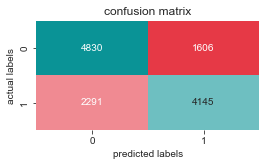

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.75      0.71      6436
           1       0.72      0.64      0.68      6436

    accuracy                           0.70     12872
   macro avg       0.70      0.70      0.70     12872
weighted avg       0.70      0.70      0.70     12872



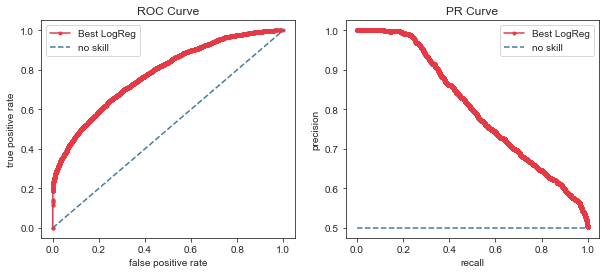

Model evaluation using K fold stratification
<<<   LogisticRegression(C=0.1)   >>>
------------------------------------------------------------
mean recall scores, train: 0.6452, test: 0.6433
mean F1 scores, train: 0.6801, test: 0.6780
mean F2 scores, train: 0.6587, test: 0.6568
mean F4 scores, train: 0.6491, test: 0.6472
mean accuracy scores, train: 0.6965, test: 0.6945


{'train_recall': 0.6451860433216037,
 'test_recall': 0.6433084628736802,
 'train_F2': 0.658703571752868,
 'test_F2': 0.6567608000565565,
 'train_F4': 0.6491036232306271,
 'test_F4': 0.6472065241082585,
 'train_accuracy': 0.6965053273509281,
 'test_accuracy': 0.6945310108805253}

In [69]:
# F1 score 
gscv_logreg = GridSearchCV(mod_logreg, param_grid, cv=5,
                          scoring="f1",
                          return_train_score=True)

gscv_logreg.fit(X_train_prepared_smt, y_train_smt)

print("Best score: {:.4f}".format(gscv_logreg.best_score_))
print("Best params: ")
display(gscv_logreg.best_params_)

best_logreg = gscv_logreg.best_estimator_

report_model_result(X_train_prepared_smt, y_train_smt, best_logreg, "Best LogReg")
evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), best_logreg)

Best score: 0.6536
Best params: 


{'C': 0.01, 'penalty': 'l2'}

Model Result: <<  Best LogReg  >>

Confusion matrix:


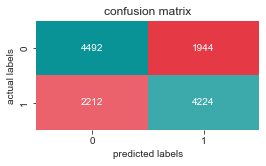

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      6436
           1       0.68      0.66      0.67      6436

    accuracy                           0.68     12872
   macro avg       0.68      0.68      0.68     12872
weighted avg       0.68      0.68      0.68     12872



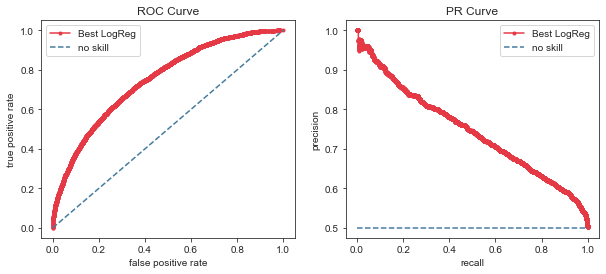

Model evaluation using K fold stratification
<<<   LogisticRegression(C=0.01)   >>>
------------------------------------------------------------
mean recall scores, train: 0.6549, test: 0.6539
mean F1 scores, train: 0.6674, test: 0.6663
mean F2 scores, train: 0.6598, test: 0.6588
mean F4 scores, train: 0.6563, test: 0.6554
mean accuracy scores, train: 0.6736, test: 0.6726


{'train_recall': 0.6548581512069569,
 'test_recall': 0.6539256234908409,
 'train_F2': 0.6597980643844044,
 'test_F2': 0.6588192694090318,
 'train_F4': 0.6563031861962441,
 'test_F4': 0.6553560690159124,
 'train_accuracy': 0.6735873626887953,
 'test_accuracy': 0.6725712087265485}

In [70]:
# F2 score 
gscv_logreg = GridSearchCV(mod_logreg, param_grid, cv=5,
                          scoring=make_scorer(f2_measure),
                          return_train_score=True)

gscv_logreg.fit(X_train_prepared_smt, y_train_smt)

print("Best score: {:.4f}".format(gscv_logreg.best_score_))
print("Best params: ")
display(gscv_logreg.best_params_)

best_logreg = gscv_logreg.best_estimator_

report_model_result(X_train_prepared_smt, y_train_smt, best_logreg, "Best LogReg")
evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), best_logreg)

Best score: 0.6500
Best params: 


{'C': 0.01, 'penalty': 'l2'}

Model Result: <<  Best LogReg  >>

Confusion matrix:


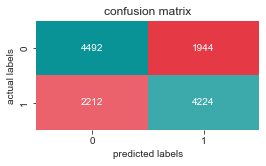

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      6436
           1       0.68      0.66      0.67      6436

    accuracy                           0.68     12872
   macro avg       0.68      0.68      0.68     12872
weighted avg       0.68      0.68      0.68     12872



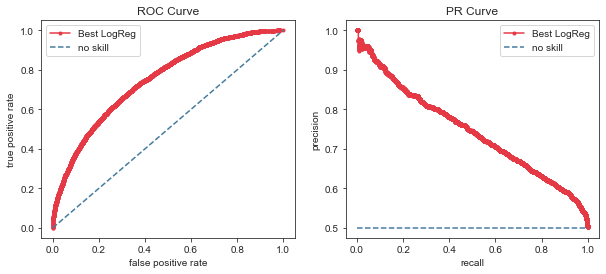

Model evaluation using K fold stratification
<<<   LogisticRegression(C=0.01)   >>>
------------------------------------------------------------
mean recall scores, train: 0.6549, test: 0.6539
mean F1 scores, train: 0.6674, test: 0.6663
mean F2 scores, train: 0.6598, test: 0.6588
mean F4 scores, train: 0.6563, test: 0.6554
mean accuracy scores, train: 0.6736, test: 0.6726


{'train_recall': 0.6548581512069569,
 'test_recall': 0.6539256234908409,
 'train_F2': 0.6597980643844044,
 'test_F2': 0.6588192694090318,
 'train_F4': 0.6563031861962441,
 'test_F4': 0.6553560690159124,
 'train_accuracy': 0.6735873626887953,
 'test_accuracy': 0.6725712087265485}

In [71]:
# F4 score 
gscv_logreg = GridSearchCV(mod_logreg, param_grid, cv=5,
                          scoring=make_scorer(f4_measure),
                          return_train_score=True)

gscv_logreg.fit(X_train_prepared_smt, y_train_smt)

print("Best score: {:.4f}".format(gscv_logreg.best_score_))
print("Best params: ")
display(gscv_logreg.best_params_)

best_logreg = gscv_logreg.best_estimator_

report_model_result(X_train_prepared_smt, y_train_smt, best_logreg, "Best LogReg")
evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), best_logreg)

## Weighted logistic regression 

Best score: 1.0000
Best params: 


{'C': 0.001, 'class_weight': {0: 1, 1: 6}}

Model Result: <<  Best LogReg Weighted  >>

Confusion matrix:


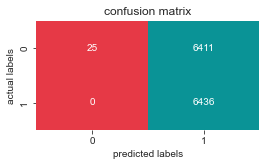

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01      6436
           1       0.50      1.00      0.67      6436

    accuracy                           0.50     12872
   macro avg       0.75      0.50      0.34     12872
weighted avg       0.75      0.50      0.34     12872



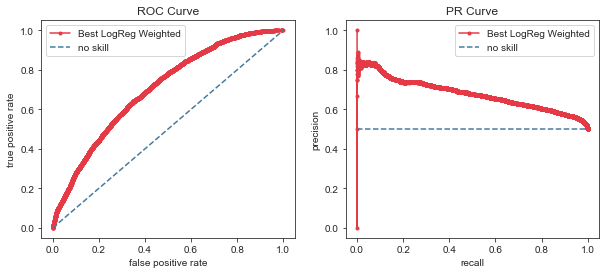

Model evaluation using K fold stratification
<<<   LogisticRegression(C=0.001, class_weight={0: 1, 1: 6})   >>>
------------------------------------------------------------
mean recall scores, train: 1.0000, test: 1.0000
mean F1 scores, train: 0.6671, test: 0.6672
mean F2 scores, train: 0.8336, test: 0.8337
mean F4 scores, train: 0.9446, test: 0.9446
mean accuracy scores, train: 0.5010, test: 0.5012


{'train_recall': 1.0,
 'test_recall': 1.0,
 'train_F2': 0.8336157805077362,
 'test_F2': 0.8336643900023634,
 'train_F4': 0.944551119704459,
 'test_F4': 0.9445694694475794,
 'train_accuracy': 0.5010164194504967,
 'test_accuracy': 0.501191210084414}

In [72]:
# recall score
param_grid = {
    "class_weight": [{0:1,1:2}, {0:1,1:3}, {0:1,1:4}, {0:1,1:5}, {0:1,1:6}, {0:1,1:7}, {0:1,1:8}, {0:1,1:9}, {0:1,1:10}],
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

gscv_logreg_weighted = GridSearchCV(mod_logreg, param_grid, cv=5,
                                    scoring="recall",
                                    return_train_score=True, n_jobs=-1)

gscv_logreg_weighted.fit(X_train_prepared_smt, y_train_smt)

print("Best score: {:.4f}".format(gscv_logreg_weighted.best_score_))
print("Best params: ")
display(gscv_logreg_weighted.best_params_)

best_logreg_weighted = gscv_logreg_weighted.best_estimator_

report_model_result(X_train_prepared_smt, y_train_smt, best_logreg_weighted, "Best LogReg Weighted")
evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), best_logreg_weighted)

Best score: 0.7132
Best params: 


{'C': 1, 'class_weight': {0: 1, 1: 2}}

Model Result: <<  Best LogReg Weighted  >>

Confusion matrix:


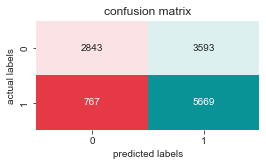

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.44      0.57      6436
           1       0.61      0.88      0.72      6436

    accuracy                           0.66     12872
   macro avg       0.70      0.66      0.64     12872
weighted avg       0.70      0.66      0.64     12872



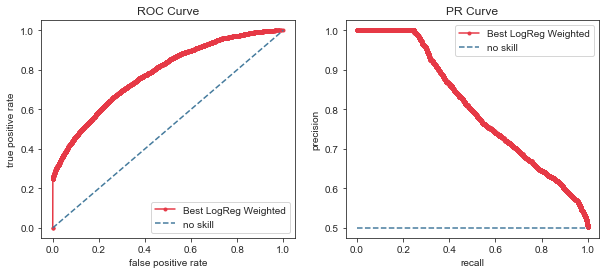

Model evaluation using K fold stratification
<<<   LogisticRegression(C=1, class_weight={0: 1, 1: 2})   >>>
------------------------------------------------------------
mean recall scores, train: 0.8815, test: 0.8797
mean F1 scores, train: 0.7223, test: 0.7207
mean F2 scores, train: 0.8101, test: 0.8084
mean F4 scores, train: 0.8592, test: 0.8575
mean accuracy scores, train: 0.6612, test: 0.6589


{'train_recall': 0.8814998589809232,
 'test_recall': 0.8797378547378548,
 'train_F2': 0.8100986957572086,
 'test_F2': 0.8083547227314252,
 'train_F4': 0.8592256179726595,
 'test_F4': 0.8574655670318577,
 'train_accuracy': 0.661150824462452,
 'test_accuracy': 0.658949867105207}

In [73]:
# use F1 score
gscv_logreg_weighted = GridSearchCV(mod_logreg, param_grid, cv=5,
                                    scoring="f1",
                                    return_train_score=True, n_jobs=-1)

gscv_logreg_weighted.fit(X_train_prepared_smt, y_train_smt)

print("Best score: {:.4f}".format(gscv_logreg_weighted.best_score_))
print("Best params: ")
display(gscv_logreg_weighted.best_params_)

best_logreg_weighted = gscv_logreg_weighted.best_estimator_

report_model_result(X_train_prepared_smt, y_train_smt, best_logreg_weighted, "Best LogReg Weighted")
evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), best_logreg_weighted)

In [74]:
# # use F2 score
# gscv_logreg_weighted = GridSearchCV(mod_logreg, param_grid, cv=5,
#                                     scoring=make_scorer(f1_score("weighted")),
#                                     return_train_score=True, n_jobs=-1)

# gscv_logreg_weighted.fit(X_train_prepared_smt, y_train_smt)

# print("Best score: {:.4f}".format(gscv_logreg_weighted.best_score_))
# print("Best params: ")
# display(gscv_logreg_weighted.best_params_)

# best_logreg_weighted = gscv_logreg_weighted.best_estimator_

# report_model_result(X_train_prepared_smt, y_train_smt, best_logreg_weighted, "Best LogReg Weighted")
# evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), best_logreg_weighted)

Best score: 0.9448
Best params: 


{'C': 0.001, 'class_weight': {0: 1, 1: 4}}

Model Result: <<  Best LogReg Weighted  >>

Confusion matrix:


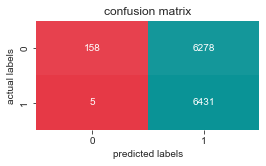

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.02      0.05      6436
           1       0.51      1.00      0.67      6436

    accuracy                           0.51     12872
   macro avg       0.74      0.51      0.36     12872
weighted avg       0.74      0.51      0.36     12872



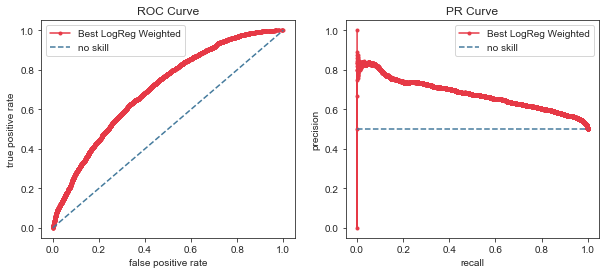

Model evaluation using K fold stratification
<<<   LogisticRegression(C=0.001, class_weight={0: 1, 1: 4})   >>>
------------------------------------------------------------
mean recall scores, train: 0.9993, test: 0.9992
mean F1 scores, train: 0.6707, test: 0.6707
mean F2 scores, train: 0.8355, test: 0.8355
mean F4 scores, train: 0.9448, test: 0.9448
mean accuracy scores, train: 0.5094, test: 0.5093


{'train_recall': 0.9992749099371745,
 'test_recall': 0.9992231600927252,
 'train_F2': 0.8355366794312993,
 'test_F2': 0.8355059225505788,
 'train_F4': 0.9448178483777719,
 'test_F4': 0.9447735775179016,
 'train_accuracy': 0.5093549457087473,
 'test_accuracy': 0.5093485011931614}

In [75]:
# F4 score
gscv_logreg_weighted = GridSearchCV(mod_logreg, param_grid, cv=5,
                                    scoring=make_scorer(f4_measure),
                                    return_train_score=True, n_jobs=-1)

gscv_logreg_weighted.fit(X_train_prepared_smt, y_train_smt)

print("Best score: {:.4f}".format(gscv_logreg_weighted.best_score_))
print("Best params: ")
display(gscv_logreg_weighted.best_params_)

best_logreg_weighted = gscv_logreg_weighted.best_estimator_

report_model_result(X_train_prepared_smt, y_train_smt, best_logreg_weighted, "Best LogReg Weighted")
evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), best_logreg_weighted)

Best score: 0.9450
Best params: 


LogisticRegression(C=1, class_weight={0: 1, 1: 5})

Model Result: <<  Best LogReg Weighted using 7 Features  >>

Confusion matrix:


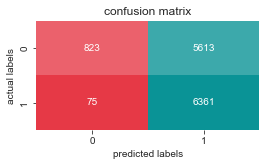

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.13      0.22      6436
           1       0.53      0.99      0.69      6436

    accuracy                           0.56     12872
   macro avg       0.72      0.56      0.46     12872
weighted avg       0.72      0.56      0.46     12872



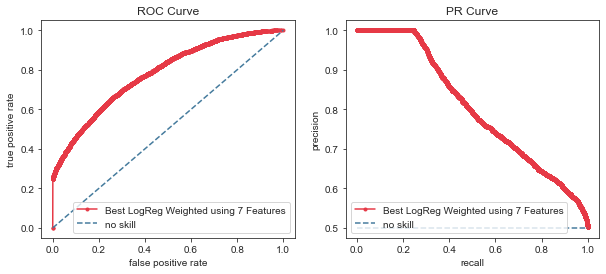

Model evaluation using K fold stratification
<<<   LogisticRegression(C=1, class_weight={0: 1, 1: 5})   >>>
------------------------------------------------------------
mean recall scores, train: 0.9884, test: 0.9877
mean F1 scores, train: 0.6910, test: 0.6905
mean F2 scores, train: 0.8433, test: 0.8427
mean F4 scores, train: 0.9408, test: 0.9401
mean accuracy scores, train: 0.5580, test: 0.5573


{'train_recall': 0.9884244791411233,
 'test_recall': 0.9877252377252376,
 'train_F2': 0.8432578416727211,
 'test_F2': 0.8426568286713523,
 'train_F4': 0.9407898184560356,
 'test_F4': 0.9401224894031012,
 'train_accuracy': 0.5580459020549888,
 'test_accuracy': 0.55733392677082}

In [76]:
X_train_kbest_7 = SelectKBest(score_func=mutual_info_classif, k=7).fit_transform(X_train_prepared_smt, y_train_smt)

gscv_logreg_7best = GridSearchCV(mod_logreg, param_grid, cv=5,
                                 scoring=make_scorer(f4_measure),
                                 return_train_score=True, n_jobs=-1)

gscv_logreg_7best.fit(X_train_kbest_7, y_train_smt)

print("Best score: {:.4f}".format(gscv_logreg_7best.best_score_))
print("Best params: ")
display(gscv_logreg_7best.best_estimator_)

best_logreg_weighted_7best = gscv_logreg_7best.best_estimator_

report_model_result(X_train_prepared_smt, y_train_smt, best_logreg_weighted_7best, "Best LogReg Weighted using 7 Features")
evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), best_logreg_weighted_7best)

## Random Forest

Best score: 0.6718
Best params: 


{'oob_score': False,
 'n_estimators': 2,
 'min_samples_split': 0.1,
 'min_samples_leaf': 30,
 'max_depth': 50,
 'criterion': 'entropy',
 'bootstrap': True}

Model Result: <<  Best Random Forest  >>

Confusion matrix:


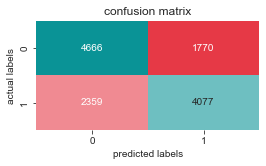

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      6436
           1       0.70      0.63      0.66      6436

    accuracy                           0.68     12872
   macro avg       0.68      0.68      0.68     12872
weighted avg       0.68      0.68      0.68     12872



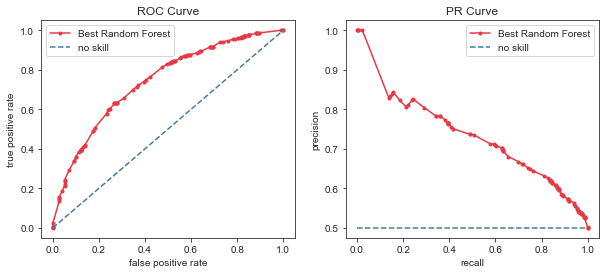

Model evaluation using K fold stratification
<<<   RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_leaf=30,
                       min_samples_split=0.1, n_estimators=2, random_state=42)   >>>
------------------------------------------------------------
mean recall scores, train: 0.6903, test: 0.6836
mean F1 scores, train: 0.6861, test: 0.6803
mean F2 scores, train: 0.6885, test: 0.6821
mean F4 scores, train: 0.6898, test: 0.6831
mean accuracy scores, train: 0.6846, test: 0.6791


{'train_recall': 0.6903224243872914,
 'test_recall': 0.6835523172479694,
 'train_F2': 0.688511915525717,
 'test_F2': 0.6821358101138923,
 'train_F4': 0.6897706431351036,
 'test_F4': 0.6831189600152161,
 'train_accuracy': 0.6845932916733727,
 'test_accuracy': 0.6790974318741309}

In [77]:
# f1 score 
param_grid = {
              "bootstrap": [True, False], 
              "criterion": ["gini", "entropy"],
              "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
              "min_samples_split":  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              "min_samples_leaf":  [1, 2, 5, 10, 20, 30],
              "n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200],
              "oob_score": [True, False]
             }

random_gscv_rf = RandomizedSearchCV(mod_rf, param_grid, cv=5,
                                    scoring='f1', n_jobs=-1,
                                    return_train_score=True, random_state=random_state)

random_gscv_rf.fit(X_train_prepared_smt, y_train_smt)

print("Best score: {:.4f}".format(random_gscv_rf.best_score_))
print("Best params: ")
display(random_gscv_rf.best_params_)

best_rf = random_gscv_rf.best_estimator_
report_model_result(X_train_prepared_smt, y_train_smt, best_rf, "Best Random Forest")
evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), best_rf)

Best score: 0.7024
Best params: 


{'criterion': 'entropy',
 'max_depth': 40,
 'min_samples_leaf': 24,
 'min_samples_split': 0.1,
 'n_estimators': 5}

Model Result: <<  Best Random Forest  >>

Confusion matrix:


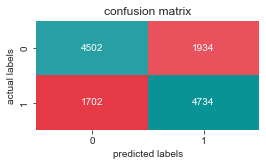

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.71      6436
           1       0.71      0.74      0.72      6436

    accuracy                           0.72     12872
   macro avg       0.72      0.72      0.72     12872
weighted avg       0.72      0.72      0.72     12872



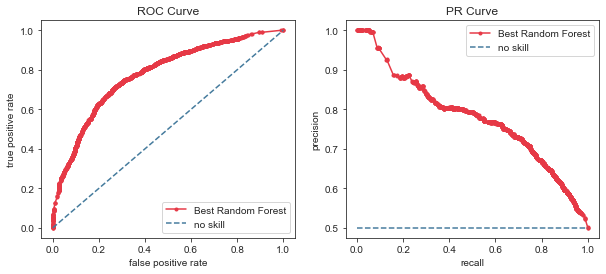

Model evaluation using K fold stratification
<<<   RandomForestClassifier(criterion='entropy', max_depth=40, min_samples_leaf=24,
                       min_samples_split=0.1, n_estimators=5, random_state=42)   >>>
------------------------------------------------------------
mean recall scores, train: 0.7321, test: 0.7206
mean F1 scores, train: 0.7174, test: 0.7078
mean F2 scores, train: 0.7261, test: 0.7154
mean F4 scores, train: 0.7303, test: 0.7190
mean accuracy scores, train: 0.7118, test: 0.7027


{'train_recall': 0.7320538197407493,
 'test_recall': 0.7205825173216478,
 'train_F2': 0.726095543059665,
 'test_F2': 0.7153944440687352,
 'train_F4': 0.7302851607148502,
 'test_F4': 0.7190437142468394,
 'train_accuracy': 0.7117839583041027,
 'test_accuracy': 0.7026882818727478}

In [78]:
param_grid = {
              "criterion": ["entropy"],
              "max_depth": [40, 45, 50, 55, 60],
              "min_samples_split": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              "min_samples_leaf":  [24, 28, 30, 38],
              "n_estimators": [1, 2, 3, 4, 5],
             }

gscv_rf = GridSearchCV(mod_rf, param_grid, cv=5,
                       scoring='f1',
                       return_train_score=True, n_jobs=-1)

gscv_rf.fit(X_train_prepared_smt, y_train_smt)

print("Best score: {:.4f}".format(gscv_rf.best_score_))
print("Best params: ")
display(gscv_rf.best_params_)

best_rf = gscv_rf.best_estimator_

report_model_result(X_train_prepared_smt, y_train_smt, best_rf, "Best Random Forest")
evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), best_rf)

Best score: 0.6837
Best params: 


{'criterion': 'entropy',
 'max_depth': 40,
 'min_samples_leaf': 38,
 'min_samples_split': 0.1,
 'n_estimators': 5}

Model Result: <<  Best Random Forest  >>

Confusion matrix:


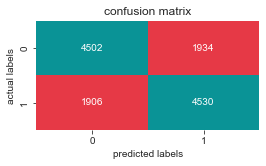

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      6436
           1       0.70      0.70      0.70      6436

    accuracy                           0.70     12872
   macro avg       0.70      0.70      0.70     12872
weighted avg       0.70      0.70      0.70     12872



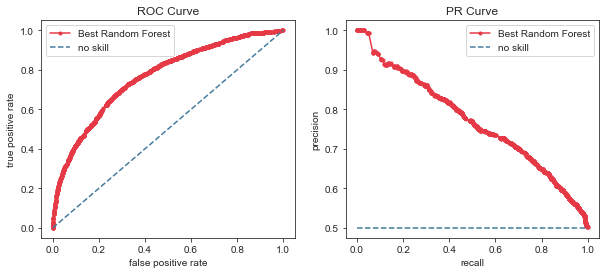

Model evaluation using K fold stratification
<<<   RandomForestClassifier(criterion='entropy', max_depth=40, min_samples_leaf=38,
                       min_samples_split=0.1, n_estimators=5, random_state=42)   >>>
------------------------------------------------------------
mean recall scores, train: 0.6960, test: 0.6876
mean F1 scores, train: 0.7016, test: 0.6940
mean F2 scores, train: 0.6982, test: 0.6901
mean F4 scores, train: 0.6967, test: 0.6884
mean accuracy scores, train: 0.7041, test: 0.6969


{'train_recall': 0.696045671167054,
 'test_recall': 0.6876427919906181,
 'train_F2': 0.6982178054909987,
 'test_F2': 0.6900970133556729,
 'train_F4': 0.6966771993221841,
 'test_F4': 0.6883551351438896,
 'train_accuracy': 0.7041121684607664,
 'test_accuracy': 0.6968884463253393}

In [79]:
param_grid = {
              "criterion": ["entropy"],
              "max_depth": [40, 45, 50, 55, 60],
              "min_samples_split": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              "min_samples_leaf":  [24, 28, 30, 38],
              "n_estimators": [1, 2, 3, 4, 5],
             }

gscv_rf_mi = GridSearchCV(mod_rf, param_grid, cv=5,
                          scoring="f1",
                          return_train_score=True, n_jobs=-1)

gscv_rf_mi.fit(X_train_prepared_smt[selected_features_mi], y_train_smt)

print("Best score: {:.4f}".format(gscv_rf_mi.best_score_))
print("Best params: ")
display(gscv_rf_mi.best_params_)

best_rf_mi = gscv_rf_mi.best_estimator_

report_model_result(X_train_prepared_smt[selected_features_mi], y_train_smt, best_rf_mi, "Best Random Forest")
evaluate_model(X_train_prepared_smt[selected_features_mi], y_train_smt.values.ravel(), best_rf_mi)

Best score: 0.8333
Best params: 


{'oob_score': False,
 'n_estimators': 16,
 'min_samples_split': 0.8,
 'min_samples_leaf': 10,
 'max_depth': 50,
 'criterion': 'entropy',
 'bootstrap': True}

Model Result: <<  Best Random Forest  >>

Confusion matrix:


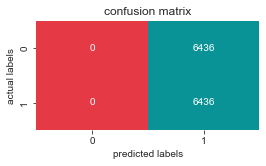

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6436
           1       0.50      1.00      0.67      6436

    accuracy                           0.50     12872
   macro avg       0.25      0.50      0.33     12872
weighted avg       0.25      0.50      0.33     12872



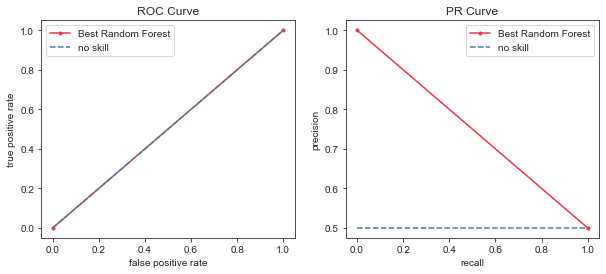

Model evaluation using K fold stratification
<<<   RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_leaf=10,
                       min_samples_split=0.8, n_estimators=16, random_state=42)   >>>
------------------------------------------------------------
mean recall scores, train: 0.9333, test: 0.9333
mean F1 scores, train: 0.6222, test: 0.6222
mean F2 scores, train: 0.7778, test: 0.7778
mean F4 scores, train: 0.8815, test: 0.8815
mean accuracy scores, train: 0.5000, test: 0.5000


{'train_recall': 0.9333333333333333,
 'test_recall': 0.9333333333333333,
 'train_F2': 0.7777759787573456,
 'test_F2': 0.7777849601263471,
 'train_F4': 0.8814808017782255,
 'test_F4': 0.8814841936409861,
 'train_accuracy': 0.4999935256223496,
 'test_accuracy': 0.5000258899676375}

In [80]:
# f2 score 
param_grid = {
              "bootstrap": [True, False], 
              "criterion": ["gini", "entropy"],
              "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
              "min_samples_split":  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              "min_samples_leaf":  [1, 2, 5, 10, 20, 30],
              "n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200],
              "oob_score": [True, False]
             }

random_gscv_rf = RandomizedSearchCV(mod_rf, param_grid, cv=5,
                                    scoring=make_scorer(f2_measure), n_jobs=-1,
                                    return_train_score=True, random_state=random_state)

random_gscv_rf.fit(X_train_prepared_smt, y_train_smt)

print("Best score: {:.4f}".format(random_gscv_rf.best_score_))
print("Best params: ")
display(random_gscv_rf.best_params_)

best_rf = random_gscv_rf.best_estimator_
report_model_result(X_train_prepared_smt, y_train_smt, best_rf, "Best Random Forest")
evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), best_rf)

Best score: 0.9444
Best params: 


{'oob_score': False,
 'n_estimators': 16,
 'min_samples_split': 0.8,
 'min_samples_leaf': 10,
 'max_depth': 50,
 'criterion': 'entropy',
 'bootstrap': True}

Model Result: <<  Best Random Forest  >>

Confusion matrix:


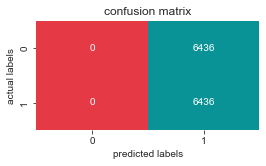

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6436
           1       0.50      1.00      0.67      6436

    accuracy                           0.50     12872
   macro avg       0.25      0.50      0.33     12872
weighted avg       0.25      0.50      0.33     12872



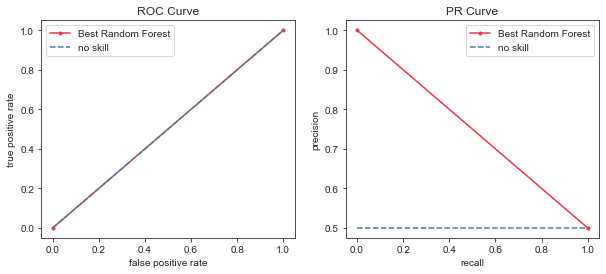

Model evaluation using K fold stratification
<<<   RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_leaf=10,
                       min_samples_split=0.8, n_estimators=16, random_state=42)   >>>
------------------------------------------------------------
mean recall scores, train: 0.9333, test: 0.9333
mean F1 scores, train: 0.6222, test: 0.6222
mean F2 scores, train: 0.7778, test: 0.7778
mean F4 scores, train: 0.8815, test: 0.8815
mean accuracy scores, train: 0.5000, test: 0.5000


{'train_recall': 0.9333333333333333,
 'test_recall': 0.9333333333333333,
 'train_F2': 0.7777759787573456,
 'test_F2': 0.7777849601263471,
 'train_F4': 0.8814808017782255,
 'test_F4': 0.8814841936409861,
 'train_accuracy': 0.4999935256223496,
 'test_accuracy': 0.5000258899676375}

In [81]:
# f4 score 
param_grid = {
              "bootstrap": [True, False], 
              "criterion": ["gini", "entropy"],
              "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
              "min_samples_split":  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              "min_samples_leaf":  [1, 2, 5, 10, 20, 30],
              "n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200],
              "oob_score": [True, False]
             }

random_gscv_rf = RandomizedSearchCV(mod_rf, param_grid, cv=5,
                                    scoring=make_scorer(f4_measure), n_jobs=-1,
                                    return_train_score=True, random_state=random_state)

random_gscv_rf.fit(X_train_prepared_smt, y_train_smt)

print("Best score: {:.4f}".format(random_gscv_rf.best_score_))
print("Best params: ")
display(random_gscv_rf.best_params_)

best_rf = random_gscv_rf.best_estimator_
report_model_result(X_train_prepared_smt, y_train_smt, best_rf, "Best Random Forest")
evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), best_rf)

## XGBoost

In [82]:
mod_xgb.get_xgb_params

<bound method XGBModel.get_xgb_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>

Model Result: <<  XGBoost  >>

[10:36:38] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion matrix:


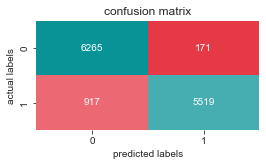

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6436
           1       0.97      0.86      0.91      6436

    accuracy                           0.92     12872
   macro avg       0.92      0.92      0.92     12872
weighted avg       0.92      0.92      0.92     12872



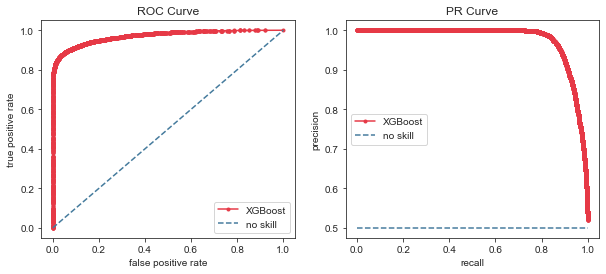

Model evaluation using K fold stratification
<<<   XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)   >>>
------------------------------------------------------------
mean recall scores, train: 0.8711, test: 0.8193
mean F1 scores, train: 0.9176, test: 0.8627
mean F2 scores, train: 0.8891, test: 0.8361
mean F4 scores, train: 0.8763, test: 0.8242
mean accuracy scores, train: 0.9217, test: 0.8696


In [83]:
mod_xgb2 = xgb.XGBClassifier(booster="dart", max_depth=4, subsample=0.7, random_state=random_state, n_jobs=-1)

report_model_result(X_train_prepared_smt, y_train_smt, mod_xgb2, "XGBoost")
scores_xgb = evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), mod_xgb2)

In [84]:
mod_xgb2 = xgb.XGBClassifier(booster="dart", max_depth=4, n_estimators=150, gamma=1, random_state=random_state, n_jobs=-1)

# report_model_result(X_train_prepared_smt, y_train_smt, mod_xgb2, "XGBoost")
scores_xgb = evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), mod_xgb2)

Model evaluation using K fold stratification
<<<   XGBClassifier(base_score=None, booster='dart', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=1, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=4,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)   >>>
------------------------------------------------------------
mean recall scores, train: 0.8915, test: 0.8226
mean F1 scores, train: 0.9377, test: 0.8747
mean F2 scores, train: 0.9094, test: 0.8427
mean F4 scores, train: 0.8967, test: 0.8284
mean accuracy scores, tr

In [85]:
mod_xgb2 = xgb.XGBClassifier(booster="dart", max_depth=3, n_estimators=150, reg_lambda=10, random_state=random_state, n_jobs=-1)

# report_model_result(X_train_prepared_smt, y_train_smt, mod_xgb2, "XGBoost")
scores_xgb = evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), mod_xgb2)

Model evaluation using K fold stratification
<<<   XGBClassifier(base_score=None, booster='dart', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=3,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=10,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)   >>>
------------------------------------------------------------
mean recall scores, train: 0.8271, test: 0.8016
mean F1 scores, train: 0.8897, test: 0.8613
mean F2 scores, train: 0.8511, test: 0.8245
mean F4 scores, train: 0.8340, test: 0.8082
mean accuracy scores, t

[10:54:55] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: 0.7735
Best params: 


{'subsample': 0.7,
 'reg_lambda': 5,
 'n_estimators': 150,
 'max_depth': 4,
 'eta': 0.1,
 'booster': 'dart'}

Model Result: <<  XGBoost  >>

[10:56:27] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion matrix:


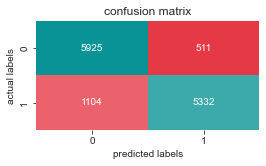

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      6436
           1       0.91      0.83      0.87      6436

    accuracy                           0.87     12872
   macro avg       0.88      0.87      0.87     12872
weighted avg       0.88      0.87      0.87     12872



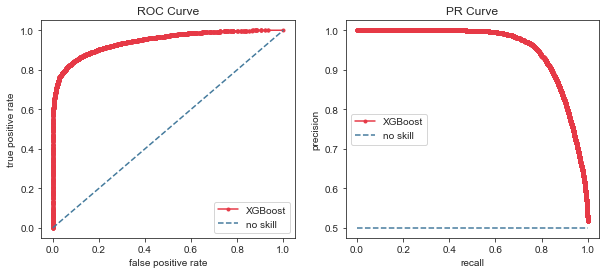

KeyboardInterrupt: 

In [87]:
# use f1 score 
param_grid = {
              "booster": ["dart"],
              "max_depth": [2, 3, 4],
              "n_estimators": [50, 100, 150],
              "eta": [0.001, 0.01, 0.1],
              "subsample": [0.6, 0.7, 0.8],
              "reg_lambda": [1, 5, 10]
}

mod_xgb = xgb.XGBClassifier(random_state=random_state)

random_gscv_xgb = RandomizedSearchCV(mod_xgb, param_grid, cv=5,
                            scoring="f1", random_state=random_state,
                            return_train_score=True, n_jobs=-1)

random_gscv_xgb.fit(X_train_prepared_smt, y_train_smt)

print("Best score: {:.4f}".format(random_gscv_xgb.best_score_))
print("Best params: ")
display(random_gscv_xgb.best_params_)

report_model_result(X_train_prepared_smt, y_train_smt, random_gscv_xgb, "XGBoost")
evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), random_gscv_xgb)

In [ ]:
# # F2 score
# random_gscv_xgb = RandomizedSearchCV(mod_xgb, param_grid, cv=5,
#                         scoring=make_scorer(f2_measure),
#                         return_train_score=True, n_jobs=-1, random_state=random_state)

# random_gscv_xgb.fit(X_train_prepared_smt, y_train_smt)

# print("Best score: {:.4f}".format(random_gscv_xgb.best_score_))
# print("Best params: ")
# display(random_gscv_xgb.best_params_)

# report_model_result(X_train_prepared_smt, y_train_smt, random_gscv_xgb, "XGBoost")
# evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), random_gscv_xgb)

In [ ]:
# # F4 score
# random_gscv_xgb = RandomizedSearchCV(mod_xgb, param_grid, cv=5,
#                         scoring=make_scorer(f4_measure),
#                         return_train_score=True, n_jobs=-1, random_state=random_state)

# random_gscv_xgb.fit(X_train_prepared_smt, y_train_smt)

# print("Best score: {:.4f}".format(random_gscv_xgb.best_score_))
# print("Best params: ")
# display(random_gscv_xgb.best_params_)

# report_model_result(X_train_prepared_smt, y_train_smt, random_gscv_xgb, "XGBoost")
# evaluate_model(X_train_prepared_smt, y_train_smt.values.ravel(), mod_xgb)

In [ ]:
# X_train_kbest_10 = SelectKBest(score_func=mutual_info_classif, k=10).fit_transform(X_train_prepared_smt, y_train_smt)


# param_grid = {
#               "max_depth": [(x+1) for x in range(10)],
# #               "min_samples_split": [(x+1)*10 for x in range(20)],
# #               "min_samples_leaf":  [(x+1)*10 for x in range(10)],
#               "n_estimators": [100, 200, 300, 400, 500, 1000, 1500, 2000],
#               "learning_rate": [0.0001, 0.001, 0.01, 0.1],
# #               "subsample": [0.6, 0.7, 0.8]
#              }


# gscv_xgb = RandomizedSearchCV(mod_xgb, param_grid, cv=5,
#                         scoring="f1", random_state=random_state,
#                         return_train_score=True, n_jobs=-1)


# gscv_xgb.fit(X_train_kbest_10, y_train_smt)

# print("Best score: {:.4f}".format(gscv_xgb.best_score_))
# print("Best params: ")
# display(gscv_xgb.best_params_)

# # best_rf_mi = random_gscv_xgb.best_estimator_

# report_model_result(X_train_kbest_10, y_train_smt, gscv_xgb, "XGBoost")
# evaluate_model(X_train_kbest_10, y_train_smt.values.ravel(), gscv_xgb)

In [ ]:
# gscv_xgb = GridSearchCV(mod_xgb, param_grid, cv=5,
#                         scoring=make_scorer(f4_measure),
#                         return_train_score=True, n_jobs=-1)

# gscv_xgb.fit(X_train_prepared_smt[selected_features_mi], y_train_smt)

# print("Best score: {:.4f}".format(gscv_xgb.best_score_))
# print("Best params: ")
# display(gscv_xgb.best_params_)

# # best_rf_mi = random_gscv_xgb.best_estimator_

# Models - Pipeline

# Result 

# Conclusion